In [1]:
import pandas as pd
import numpy as np
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

#from google.colab import files
import io

train_df = pd.read_csv('data/train_df.csv')
print(train_df.head)

test_df = pd.read_csv('data/test_df.csv')
print(test_df.head)


<bound method NDFrame.head of       tBodyAccmeanX  tBodyAccmeanY  tBodyAccmeanZ  tBodyAccstdX  tBodyAccstdY  \
0          0.278419      -0.016411      -0.123520     -0.998245     -0.975300   
1          0.279653      -0.019467      -0.113462     -0.995380     -0.967187   
2          0.279174      -0.026201      -0.123283     -0.996091     -0.983403   
3          0.276629      -0.016570      -0.115362     -0.998139     -0.980817   
4          0.277199      -0.010098      -0.105137     -0.997335     -0.990487   
...             ...            ...            ...           ...           ...   
7346       0.299665      -0.057193      -0.181233     -0.195387      0.039905   
7347       0.273853      -0.007749      -0.147468     -0.235309      0.004816   
7348       0.273387      -0.017011      -0.045022     -0.218218     -0.103822   
7349       0.289654      -0.018843      -0.158281     -0.219139     -0.111412   
7350       0.351503      -0.012423      -0.203867     -0.269270     -0.087212  

In [2]:
print(train_df.drop(['activity_name'], axis = 1))

train_df_2 = train_df.drop(['activity_name'], axis = 1)

train_arr = train_df_2.to_numpy()

x_train = train_arr[:, 0:561]
print(x_train.shape)

print(train_arr[:, 562])
y_train = train_arr[:, 562]
print(y_train.shape)

#process test data
print(test_df.head)
test_df_2 = test_df.drop(['activity_name'], axis = 1)
print(test_df_2)

test_arr = test_df_2.to_numpy()

x_test = test_arr[:, 0:561]
print(x_test.shape)

print(test_arr[:, 562])
y_test = test_arr[:, 562]
print(y_test.shape)

      tBodyAccmeanX  tBodyAccmeanY  tBodyAccmeanZ  tBodyAccstdX  tBodyAccstdY  \
0          0.278419      -0.016411      -0.123520     -0.998245     -0.975300   
1          0.279653      -0.019467      -0.113462     -0.995380     -0.967187   
2          0.279174      -0.026201      -0.123283     -0.996091     -0.983403   
3          0.276629      -0.016570      -0.115362     -0.998139     -0.980817   
4          0.277199      -0.010098      -0.105137     -0.997335     -0.990487   
...             ...            ...            ...           ...           ...   
7346       0.299665      -0.057193      -0.181233     -0.195387      0.039905   
7347       0.273853      -0.007749      -0.147468     -0.235309      0.004816   
7348       0.273387      -0.017011      -0.045022     -0.218218     -0.103822   
7349       0.289654      -0.018843      -0.158281     -0.219139     -0.111412   
7350       0.351503      -0.012423      -0.203867     -0.269270     -0.087212   

      tBodyAccstdZ  tBodyAc

In [3]:
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

print("Machine learning libraries loaded")
print (x_train.shape)
print (x_test.shape)

Machine learning libraries loaded
(7351, 561)
(2946, 561)


In [4]:
def predict_y(x_train, x_test, y_train, y_test):
    #Use the transformed data to make predictions 
    from sklearn.svm import SVC
    from sklearn import metrics

    svc = SVC(C=10, gamma= 0.01)
    #train model
    svc.fit(x_train, y_train)
    #test
    y_pred = svc.predict(x_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    #var = metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average')
    print(acc)
    #print(metrics.confusion_matrix(y_test, y_pred))
    #print(metrics.classification_report(y_test, y_pred))

    return acc
print("Function for prediction")

Function for prediction


In [5]:
component_list = [i for i in range(100, 210, 10)]
#mid_node_list = [j for j in range(250, 375, 25)]

#setting up models

component_acc = []
component_var = []

for c in range(len(component_list)):
    input_shape = x_train.shape[1]
    inputs = Input(shape=(input_shape))

    #Encoder
    encoded = Dense(250, activation='relu')(inputs)
    encoded = Dense(component_list[c], activation='relu')(encoded)

    #Decoder
    decoded = Dense(250, activation='relu')(encoded)
    decoded = Dense(input_shape)(decoded)

    #Model setup, summary and compilation
    deep_autoencoder = Model(inputs, decoded)
    deep_autoencoder.summary()
    deep_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), 
                             loss=tf.keras.losses.MeanSquaredError(), 
                             metrics=['accuracy'])

    #training the models

    batch_size = 512

    history = deep_autoencoder.fit(
        x_train,
        x_train,
        epochs=500,
        batch_size=batch_size,
        validation_split=0.2
    )

    #Encode X data
    encoder = Model(inputs, encoded)
    encoded_X_train = encoder(x_train).numpy()
    encoded_X_test = encoder(x_test).numpy()
    
    #variation looks at how the encoding/decoding affects
    y_var = deep_autoencoder.predict(x_test)
    variation = explained_variance_score(x_test, y_var, multioutput='uniform_average')
    
    accuracy = predict_y(encoded_X_train, encoded_X_test, y_train, y_test)
    component_acc.append(accuracy)
    component_var.append(variation)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]             0         
_________________________________________________________________
dense (Dense)                (None, 250)               140500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_2 (Dense)              (None, 250)               25250     
_________________________________________________________________
dense_3 (Dense)              (None, 561)               140811    
Total params: 331,661
Trainable params: 331,661
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
12/12 [==============================] - 0s 30ms/step - loss: 0.3090 - accuracy: 0.0481 - val_loss: 0.

12/12 [==============================] - 0s 11ms/step - loss: 0.0106 - accuracy: 0.2757 - val_loss: 0.0109 - val_accuracy: 0.2400
Epoch 52/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0102 - accuracy: 0.2721 - val_loss: 0.0105 - val_accuracy: 0.2570
Epoch 53/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0100 - accuracy: 0.2794 - val_loss: 0.0104 - val_accuracy: 0.2740
Epoch 54/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0099 - accuracy: 0.2764 - val_loss: 0.0102 - val_accuracy: 0.2604
Epoch 55/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0098 - accuracy: 0.2767 - val_loss: 0.0101 - val_accuracy: 0.2814
Epoch 56/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0097 - accuracy: 0.2832 - val_loss: 0.0101 - val_accuracy: 0.2835
Epoch 57/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0096 - accuracy: 0.2811 - val_loss: 0.0100 - val_accuracy: 0.2740
Epoch 58/500

12/12 [==============================] - 0s 11ms/step - loss: 0.0072 - accuracy: 0.3026 - val_loss: 0.0079 - val_accuracy: 0.2760
Epoch 109/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0074 - accuracy: 0.3126 - val_loss: 0.0079 - val_accuracy: 0.2325
Epoch 110/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0072 - accuracy: 0.3024 - val_loss: 0.0078 - val_accuracy: 0.2889
Epoch 111/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0071 - accuracy: 0.3155 - val_loss: 0.0076 - val_accuracy: 0.2651
Epoch 112/500
12/12 [==============================] - 0s 10ms/step - loss: 0.0071 - accuracy: 0.3077 - val_loss: 0.0076 - val_accuracy: 0.2726
Epoch 113/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0071 - accuracy: 0.3088 - val_loss: 0.0076 - val_accuracy: 0.2964
Epoch 114/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0071 - accuracy: 0.3060 - val_loss: 0.0079 - val_accuracy: 0.3066
Epoch 

Epoch 165/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0063 - accuracy: 0.3415 - val_loss: 0.0069 - val_accuracy: 0.2808
Epoch 166/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0063 - accuracy: 0.3310 - val_loss: 0.0069 - val_accuracy: 0.2991
Epoch 167/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0062 - accuracy: 0.3371 - val_loss: 0.0068 - val_accuracy: 0.3270
Epoch 168/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0062 - accuracy: 0.3355 - val_loss: 0.0068 - val_accuracy: 0.2889
Epoch 169/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0063 - accuracy: 0.3405 - val_loss: 0.0071 - val_accuracy: 0.2644
Epoch 170/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0063 - accuracy: 0.3354 - val_loss: 0.0069 - val_accuracy: 0.3012
Epoch 171/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0062 - accuracy: 0.3401 - val_loss: 0.0068 - val_accuracy:

Epoch 222/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0058 - accuracy: 0.3464 - val_loss: 0.0065 - val_accuracy: 0.3501
Epoch 223/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0059 - accuracy: 0.3563 - val_loss: 0.0069 - val_accuracy: 0.3474
Epoch 224/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0060 - accuracy: 0.3410 - val_loss: 0.0065 - val_accuracy: 0.3950
Epoch 225/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0058 - accuracy: 0.3532 - val_loss: 0.0065 - val_accuracy: 0.3467
Epoch 226/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0058 - accuracy: 0.3519 - val_loss: 0.0065 - val_accuracy: 0.3460
Epoch 227/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0058 - accuracy: 0.3507 - val_loss: 0.0067 - val_accuracy: 0.3372
Epoch 228/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0059 - accuracy: 0.3449 - val_loss: 0.0065 - val_accuracy:

Epoch 279/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0055 - accuracy: 0.3430 - val_loss: 0.0063 - val_accuracy: 0.3440
Epoch 280/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0055 - accuracy: 0.3602 - val_loss: 0.0063 - val_accuracy: 0.3066
Epoch 281/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0056 - accuracy: 0.3529 - val_loss: 0.0063 - val_accuracy: 0.3685
Epoch 282/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0055 - accuracy: 0.3537 - val_loss: 0.0064 - val_accuracy: 0.3351
Epoch 283/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0055 - accuracy: 0.3682 - val_loss: 0.0063 - val_accuracy: 0.3324
Epoch 284/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0054 - accuracy: 0.3580 - val_loss: 0.0063 - val_accuracy: 0.3929
Epoch 285/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0055 - accuracy: 0.3658 - val_loss: 0.0063 - val_accuracy:

Epoch 336/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0053 - accuracy: 0.3588 - val_loss: 0.0064 - val_accuracy: 0.3555
Epoch 337/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0053 - accuracy: 0.3655 - val_loss: 0.0062 - val_accuracy: 0.3351
Epoch 338/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0053 - accuracy: 0.3673 - val_loss: 0.0061 - val_accuracy: 0.3120
Epoch 339/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0052 - accuracy: 0.3605 - val_loss: 0.0061 - val_accuracy: 0.3678
Epoch 340/500
12/12 [==============================] - 0s 10ms/step - loss: 0.0052 - accuracy: 0.3551 - val_loss: 0.0061 - val_accuracy: 0.3712
Epoch 341/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0052 - accuracy: 0.3701 - val_loss: 0.0062 - val_accuracy: 0.2937
Epoch 342/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0054 - accuracy: 0.3558 - val_loss: 0.0063 - val_accuracy:

Epoch 393/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3806 - val_loss: 0.0060 - val_accuracy: 0.3399
Epoch 394/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3656 - val_loss: 0.0061 - val_accuracy: 0.3780
Epoch 395/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0050 - accuracy: 0.3549 - val_loss: 0.0060 - val_accuracy: 0.3603
Epoch 396/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0050 - accuracy: 0.3680 - val_loss: 0.0060 - val_accuracy: 0.3494
Epoch 397/500
12/12 [==============================] - 0s 10ms/step - loss: 0.0050 - accuracy: 0.3776 - val_loss: 0.0060 - val_accuracy: 0.3426
Epoch 398/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3736 - val_loss: 0.0063 - val_accuracy: 0.3664
Epoch 399/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3651 - val_loss: 0.0061 - val_accuracy:

Epoch 450/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0049 - accuracy: 0.3762 - val_loss: 0.0060 - val_accuracy: 0.3576
Epoch 451/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0049 - accuracy: 0.3808 - val_loss: 0.0059 - val_accuracy: 0.3882
Epoch 452/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0049 - accuracy: 0.3728 - val_loss: 0.0059 - val_accuracy: 0.3270
Epoch 453/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0048 - accuracy: 0.3888 - val_loss: 0.0059 - val_accuracy: 0.3093
Epoch 454/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0048 - accuracy: 0.3813 - val_loss: 0.0059 - val_accuracy: 0.3956
Epoch 455/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0048 - accuracy: 0.3864 - val_loss: 0.0059 - val_accuracy: 0.3766
Epoch 456/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0049 - accuracy: 0.3709 - val_loss: 0.0061 - val_accuracy:

12/12 [==============================] - 0s 20ms/step - loss: 0.3083 - accuracy: 0.0408 - val_loss: 0.0837 - val_accuracy: 0.0836
Epoch 2/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0738 - accuracy: 0.1468 - val_loss: 0.0497 - val_accuracy: 0.1693
Epoch 3/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0458 - accuracy: 0.1469 - val_loss: 0.0348 - val_accuracy: 0.2604
Epoch 4/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0374 - accuracy: 0.2085 - val_loss: 0.0316 - val_accuracy: 0.2753
Epoch 5/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0347 - accuracy: 0.1818 - val_loss: 0.0297 - val_accuracy: 0.2753
Epoch 6/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0326 - accuracy: 0.1461 - val_loss: 0.0279 - val_accuracy: 0.2264
Epoch 7/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0305 - accuracy: 0.1752 - val_loss: 0.0260 - val_accuracy: 0.2672
Epoch 8/500
12/12 

12/12 [==============================] - 0s 11ms/step - loss: 0.0094 - accuracy: 0.2884 - val_loss: 0.0095 - val_accuracy: 0.1897
Epoch 59/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0093 - accuracy: 0.2845 - val_loss: 0.0095 - val_accuracy: 0.2699
Epoch 60/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0092 - accuracy: 0.2847 - val_loss: 0.0097 - val_accuracy: 0.1842
Epoch 61/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0092 - accuracy: 0.2864 - val_loss: 0.0094 - val_accuracy: 0.2196
Epoch 62/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0091 - accuracy: 0.2820 - val_loss: 0.0093 - val_accuracy: 0.2114
Epoch 63/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0092 - accuracy: 0.2903 - val_loss: 0.0092 - val_accuracy: 0.2250
Epoch 64/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0089 - accuracy: 0.2886 - val_loss: 0.0092 - val_accuracy: 0.2264
Epoch 65/500

12/12 [==============================] - 0s 11ms/step - loss: 0.0068 - accuracy: 0.3192 - val_loss: 0.0071 - val_accuracy: 0.3168
Epoch 116/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0067 - accuracy: 0.3219 - val_loss: 0.0071 - val_accuracy: 0.3419
Epoch 117/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0067 - accuracy: 0.3211 - val_loss: 0.0071 - val_accuracy: 0.3406
Epoch 118/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0067 - accuracy: 0.3204 - val_loss: 0.0070 - val_accuracy: 0.3243
Epoch 119/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0066 - accuracy: 0.3167 - val_loss: 0.0070 - val_accuracy: 0.3297
Epoch 120/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0066 - accuracy: 0.3272 - val_loss: 0.0070 - val_accuracy: 0.3256
Epoch 121/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0067 - accuracy: 0.3252 - val_loss: 0.0071 - val_accuracy: 0.2984
Epoch 

Epoch 172/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0058 - accuracy: 0.3272 - val_loss: 0.0061 - val_accuracy: 0.3698
Epoch 173/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0057 - accuracy: 0.3406 - val_loss: 0.0061 - val_accuracy: 0.3419
Epoch 174/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0057 - accuracy: 0.3383 - val_loss: 0.0061 - val_accuracy: 0.3311
Epoch 175/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0057 - accuracy: 0.3327 - val_loss: 0.0061 - val_accuracy: 0.3528
Epoch 176/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0057 - accuracy: 0.3488 - val_loss: 0.0061 - val_accuracy: 0.2780
Epoch 177/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0057 - accuracy: 0.3255 - val_loss: 0.0065 - val_accuracy: 0.3528
Epoch 178/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0060 - accuracy: 0.3238 - val_loss: 0.0063 - val_accuracy:

Epoch 229/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0052 - accuracy: 0.3570 - val_loss: 0.0059 - val_accuracy: 0.2692
Epoch 230/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0055 - accuracy: 0.3323 - val_loss: 0.0058 - val_accuracy: 0.3827
Epoch 231/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0052 - accuracy: 0.3429 - val_loss: 0.0057 - val_accuracy: 0.3787
Epoch 232/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3594 - val_loss: 0.0056 - val_accuracy: 0.2971
Epoch 233/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3422 - val_loss: 0.0056 - val_accuracy: 0.3651
Epoch 234/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3522 - val_loss: 0.0056 - val_accuracy: 0.3365
Epoch 235/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3509 - val_loss: 0.0057 - val_accuracy:

Epoch 286/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0048 - accuracy: 0.3490 - val_loss: 0.0054 - val_accuracy: 0.3719
Epoch 287/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0047 - accuracy: 0.3646 - val_loss: 0.0054 - val_accuracy: 0.3215
Epoch 288/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0047 - accuracy: 0.3544 - val_loss: 0.0054 - val_accuracy: 0.3114
Epoch 289/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0049 - accuracy: 0.3505 - val_loss: 0.0057 - val_accuracy: 0.3107
Epoch 290/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0048 - accuracy: 0.3420 - val_loss: 0.0054 - val_accuracy: 0.3623
Epoch 291/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0047 - accuracy: 0.3622 - val_loss: 0.0054 - val_accuracy: 0.3535
Epoch 292/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0047 - accuracy: 0.3583 - val_loss: 0.0053 - val_accuracy:

Epoch 343/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0044 - accuracy: 0.3670 - val_loss: 0.0052 - val_accuracy: 0.3501
Epoch 344/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0046 - accuracy: 0.3597 - val_loss: 0.0052 - val_accuracy: 0.3555
Epoch 345/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0045 - accuracy: 0.3599 - val_loss: 0.0052 - val_accuracy: 0.3433
Epoch 346/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0045 - accuracy: 0.3612 - val_loss: 0.0051 - val_accuracy: 0.3406
Epoch 347/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0044 - accuracy: 0.3704 - val_loss: 0.0051 - val_accuracy: 0.3474
Epoch 348/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0044 - accuracy: 0.3629 - val_loss: 0.0052 - val_accuracy: 0.3317
Epoch 349/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0044 - accuracy: 0.3588 - val_loss: 0.0051 - val_accuracy:

Epoch 400/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3821 - val_loss: 0.0050 - val_accuracy: 0.3651
Epoch 401/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0042 - accuracy: 0.3650 - val_loss: 0.0049 - val_accuracy: 0.3562
Epoch 402/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0042 - accuracy: 0.3794 - val_loss: 0.0049 - val_accuracy: 0.3827
Epoch 403/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0042 - accuracy: 0.3748 - val_loss: 0.0049 - val_accuracy: 0.3671
Epoch 404/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0042 - accuracy: 0.3828 - val_loss: 0.0052 - val_accuracy: 0.3379
Epoch 405/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0045 - accuracy: 0.3687 - val_loss: 0.0051 - val_accuracy: 0.3270
Epoch 406/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0042 - accuracy: 0.3781 - val_loss: 0.0049 - val_accuracy:

Epoch 457/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3806 - val_loss: 0.0050 - val_accuracy: 0.3821
Epoch 458/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0045 - accuracy: 0.3650 - val_loss: 0.0051 - val_accuracy: 0.3895
Epoch 459/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.3787 - val_loss: 0.0048 - val_accuracy: 0.3644
Epoch 460/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.3767 - val_loss: 0.0050 - val_accuracy: 0.3814
Epoch 461/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3820 - val_loss: 0.0048 - val_accuracy: 0.3358
Epoch 462/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3842 - val_loss: 0.0048 - val_accuracy: 0.3372
Epoch 463/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3745 - val_loss: 0.0049 - val_accuracy:

Epoch 7/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0290 - accuracy: 0.1614 - val_loss: 0.0250 - val_accuracy: 0.1829
Epoch 8/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0266 - accuracy: 0.1811 - val_loss: 0.0235 - val_accuracy: 0.1774
Epoch 9/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0249 - accuracy: 0.1811 - val_loss: 0.0224 - val_accuracy: 0.2046
Epoch 10/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0236 - accuracy: 0.1983 - val_loss: 0.0216 - val_accuracy: 0.1815
Epoch 11/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0225 - accuracy: 0.2049 - val_loss: 0.0208 - val_accuracy: 0.1835
Epoch 12/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0215 - accuracy: 0.2126 - val_loss: 0.0200 - val_accuracy: 0.2073
Epoch 13/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0206 - accuracy: 0.2078 - val_loss: 0.0192 - val_accuracy: 0.1849
Ep

12/12 [==============================] - 0s 11ms/step - loss: 0.0083 - accuracy: 0.2874 - val_loss: 0.0085 - val_accuracy: 0.3508
Epoch 65/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0081 - accuracy: 0.3012 - val_loss: 0.0084 - val_accuracy: 0.3243
Epoch 66/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0081 - accuracy: 0.3048 - val_loss: 0.0085 - val_accuracy: 0.3243
Epoch 67/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0080 - accuracy: 0.2906 - val_loss: 0.0084 - val_accuracy: 0.3528
Epoch 68/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0080 - accuracy: 0.3002 - val_loss: 0.0083 - val_accuracy: 0.3508
Epoch 69/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0079 - accuracy: 0.2976 - val_loss: 0.0082 - val_accuracy: 0.3719
Epoch 70/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0079 - accuracy: 0.2998 - val_loss: 0.0082 - val_accuracy: 0.3467
Epoch 71/500

12/12 [==============================] - 0s 11ms/step - loss: 0.0059 - accuracy: 0.3141 - val_loss: 0.0062 - val_accuracy: 0.3018
Epoch 122/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0058 - accuracy: 0.3231 - val_loss: 0.0063 - val_accuracy: 0.3141
Epoch 123/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0058 - accuracy: 0.3175 - val_loss: 0.0063 - val_accuracy: 0.3331
Epoch 124/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0064 - accuracy: 0.3092 - val_loss: 0.0066 - val_accuracy: 0.3453
Epoch 125/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0060 - accuracy: 0.3185 - val_loss: 0.0062 - val_accuracy: 0.2957
Epoch 126/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0057 - accuracy: 0.3189 - val_loss: 0.0062 - val_accuracy: 0.2930
Epoch 127/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0057 - accuracy: 0.3209 - val_loss: 0.0061 - val_accuracy: 0.3515
Epoch 

Epoch 178/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0049 - accuracy: 0.3410 - val_loss: 0.0060 - val_accuracy: 0.4058
Epoch 179/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0054 - accuracy: 0.3308 - val_loss: 0.0055 - val_accuracy: 0.2957
Epoch 180/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0049 - accuracy: 0.3395 - val_loss: 0.0052 - val_accuracy: 0.3814
Epoch 181/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0048 - accuracy: 0.3388 - val_loss: 0.0052 - val_accuracy: 0.3596
Epoch 182/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0048 - accuracy: 0.3418 - val_loss: 0.0051 - val_accuracy: 0.3617
Epoch 183/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0047 - accuracy: 0.3444 - val_loss: 0.0052 - val_accuracy: 0.3603
Epoch 184/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0048 - accuracy: 0.3432 - val_loss: 0.0052 - val_accuracy:

Epoch 235/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3551 - val_loss: 0.0047 - val_accuracy: 0.3732
Epoch 236/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3622 - val_loss: 0.0046 - val_accuracy: 0.3426
Epoch 237/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3658 - val_loss: 0.0047 - val_accuracy: 0.3549
Epoch 238/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3570 - val_loss: 0.0046 - val_accuracy: 0.3345
Epoch 239/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3587 - val_loss: 0.0050 - val_accuracy: 0.3270
Epoch 240/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0046 - accuracy: 0.3451 - val_loss: 0.0047 - val_accuracy: 0.3623
Epoch 241/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3519 - val_loss: 0.0046 - val_accuracy:

Epoch 292/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3473 - val_loss: 0.0044 - val_accuracy: 0.4072
Epoch 293/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3643 - val_loss: 0.0043 - val_accuracy: 0.2937
Epoch 294/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3719 - val_loss: 0.0044 - val_accuracy: 0.3481
Epoch 295/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3483 - val_loss: 0.0046 - val_accuracy: 0.3039
Epoch 296/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3531 - val_loss: 0.0044 - val_accuracy: 0.3059
Epoch 297/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3645 - val_loss: 0.0044 - val_accuracy: 0.3304
Epoch 298/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3645 - val_loss: 0.0043 - val_accuracy:

Epoch 349/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0038 - accuracy: 0.3675 - val_loss: 0.0043 - val_accuracy: 0.2835
Epoch 350/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3660 - val_loss: 0.0043 - val_accuracy: 0.3249
Epoch 351/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0038 - accuracy: 0.3702 - val_loss: 0.0042 - val_accuracy: 0.3059
Epoch 352/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3486 - val_loss: 0.0042 - val_accuracy: 0.3562
Epoch 353/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3696 - val_loss: 0.0042 - val_accuracy: 0.3508
Epoch 354/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3673 - val_loss: 0.0044 - val_accuracy: 0.3487
Epoch 355/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3514 - val_loss: 0.0042 - val_accuracy:

Epoch 406/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3588 - val_loss: 0.0041 - val_accuracy: 0.3576
Epoch 407/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0035 - accuracy: 0.3599 - val_loss: 0.0041 - val_accuracy: 0.3447
Epoch 408/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0035 - accuracy: 0.3651 - val_loss: 0.0041 - val_accuracy: 0.3705
Epoch 409/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3665 - val_loss: 0.0047 - val_accuracy: 0.2842
Epoch 410/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0038 - accuracy: 0.3396 - val_loss: 0.0041 - val_accuracy: 0.3691
Epoch 411/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3753 - val_loss: 0.0041 - val_accuracy: 0.3481
Epoch 412/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3650 - val_loss: 0.0041 - val_accuracy:

Epoch 463/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3888 - val_loss: 0.0039 - val_accuracy: 0.4120
Epoch 464/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3752 - val_loss: 0.0039 - val_accuracy: 0.4174
Epoch 465/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3719 - val_loss: 0.0041 - val_accuracy: 0.3440
Epoch 466/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3740 - val_loss: 0.0040 - val_accuracy: 0.3596
Epoch 467/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3706 - val_loss: 0.0039 - val_accuracy: 0.3141
Epoch 468/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3702 - val_loss: 0.0039 - val_accuracy: 0.3861
Epoch 469/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3730 - val_loss: 0.0040 - val_accuracy:

Epoch 13/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0214 - accuracy: 0.1912 - val_loss: 0.0201 - val_accuracy: 0.2311
Epoch 14/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0206 - accuracy: 0.2049 - val_loss: 0.0195 - val_accuracy: 0.2155
Epoch 15/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0199 - accuracy: 0.2056 - val_loss: 0.0188 - val_accuracy: 0.2434
Epoch 16/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0192 - accuracy: 0.2092 - val_loss: 0.0182 - val_accuracy: 0.2114
Epoch 17/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0185 - accuracy: 0.2206 - val_loss: 0.0178 - val_accuracy: 0.2291
Epoch 18/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0179 - accuracy: 0.2235 - val_loss: 0.0172 - val_accuracy: 0.2604
Epoch 19/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0172 - accuracy: 0.2357 - val_loss: 0.0165 - val_accuracy: 0.2318

12/12 [==============================] - 0s 11ms/step - loss: 0.0081 - accuracy: 0.2980 - val_loss: 0.0084 - val_accuracy: 0.3148
Epoch 71/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0080 - accuracy: 0.3073 - val_loss: 0.0083 - val_accuracy: 0.2950
Epoch 72/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0081 - accuracy: 0.3041 - val_loss: 0.0085 - val_accuracy: 0.3066
Epoch 73/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0079 - accuracy: 0.2973 - val_loss: 0.0082 - val_accuracy: 0.3012
Epoch 74/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0078 - accuracy: 0.3020 - val_loss: 0.0081 - val_accuracy: 0.3018
Epoch 75/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0077 - accuracy: 0.3087 - val_loss: 0.0081 - val_accuracy: 0.3018
Epoch 76/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0077 - accuracy: 0.3124 - val_loss: 0.0082 - val_accuracy: 0.3059
Epoch 77/500

12/12 [==============================] - 0s 11ms/step - loss: 0.0062 - accuracy: 0.3260 - val_loss: 0.0066 - val_accuracy: 0.3814
Epoch 128/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0060 - accuracy: 0.3248 - val_loss: 0.0065 - val_accuracy: 0.3861
Epoch 129/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0060 - accuracy: 0.3413 - val_loss: 0.0064 - val_accuracy: 0.3759
Epoch 130/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0060 - accuracy: 0.3444 - val_loss: 0.0065 - val_accuracy: 0.3080
Epoch 131/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0060 - accuracy: 0.3427 - val_loss: 0.0065 - val_accuracy: 0.2869
Epoch 132/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0062 - accuracy: 0.3320 - val_loss: 0.0076 - val_accuracy: 0.3521
Epoch 133/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0063 - accuracy: 0.3177 - val_loss: 0.0064 - val_accuracy: 0.3739
Epoch 

Epoch 184/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0052 - accuracy: 0.3364 - val_loss: 0.0057 - val_accuracy: 0.3603
Epoch 185/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3471 - val_loss: 0.0057 - val_accuracy: 0.3766
Epoch 186/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0052 - accuracy: 0.3486 - val_loss: 0.0057 - val_accuracy: 0.3277
Epoch 187/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3371 - val_loss: 0.0057 - val_accuracy: 0.4222
Epoch 188/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3493 - val_loss: 0.0057 - val_accuracy: 0.3467
Epoch 189/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3526 - val_loss: 0.0057 - val_accuracy: 0.3807
Epoch 190/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0052 - accuracy: 0.3478 - val_loss: 0.0059 - val_accuracy:

Epoch 241/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0047 - accuracy: 0.3493 - val_loss: 0.0053 - val_accuracy: 0.3576
Epoch 242/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0047 - accuracy: 0.3527 - val_loss: 0.0052 - val_accuracy: 0.3467
Epoch 243/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0047 - accuracy: 0.3451 - val_loss: 0.0052 - val_accuracy: 0.3678
Epoch 244/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0047 - accuracy: 0.3505 - val_loss: 0.0052 - val_accuracy: 0.3515
Epoch 245/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0048 - accuracy: 0.3444 - val_loss: 0.0054 - val_accuracy: 0.3453
Epoch 246/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0047 - accuracy: 0.3515 - val_loss: 0.0052 - val_accuracy: 0.3739
Epoch 247/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0046 - accuracy: 0.3485 - val_loss: 0.0052 - val_accuracy:

Epoch 298/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0044 - accuracy: 0.3612 - val_loss: 0.0050 - val_accuracy: 0.3018
Epoch 299/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0044 - accuracy: 0.3568 - val_loss: 0.0052 - val_accuracy: 0.3990
Epoch 300/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0045 - accuracy: 0.3537 - val_loss: 0.0050 - val_accuracy: 0.3698
Epoch 301/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3626 - val_loss: 0.0049 - val_accuracy: 0.3066
Epoch 302/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3577 - val_loss: 0.0049 - val_accuracy: 0.3521
Epoch 303/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3544 - val_loss: 0.0049 - val_accuracy: 0.3549
Epoch 304/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0045 - accuracy: 0.3452 - val_loss: 0.0055 - val_accuracy:

Epoch 355/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.3714 - val_loss: 0.0048 - val_accuracy: 0.3793
Epoch 356/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0044 - accuracy: 0.3706 - val_loss: 0.0059 - val_accuracy: 0.2529
Epoch 357/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0046 - accuracy: 0.3493 - val_loss: 0.0048 - val_accuracy: 0.4140
Epoch 358/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0042 - accuracy: 0.3655 - val_loss: 0.0048 - val_accuracy: 0.3494
Epoch 359/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.3689 - val_loss: 0.0048 - val_accuracy: 0.3970
Epoch 360/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.3685 - val_loss: 0.0048 - val_accuracy: 0.4072
Epoch 361/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.3707 - val_loss: 0.0048 - val_accuracy:

Epoch 412/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3728 - val_loss: 0.0047 - val_accuracy: 0.3426
Epoch 413/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3770 - val_loss: 0.0047 - val_accuracy: 0.4154
Epoch 414/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3663 - val_loss: 0.0047 - val_accuracy: 0.4018
Epoch 415/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3682 - val_loss: 0.0048 - val_accuracy: 0.3304
Epoch 416/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0042 - accuracy: 0.3653 - val_loss: 0.0052 - val_accuracy: 0.3508
Epoch 417/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.3651 - val_loss: 0.0047 - val_accuracy: 0.3467
Epoch 418/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3769 - val_loss: 0.0047 - val_accuracy:

Epoch 469/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3776 - val_loss: 0.0046 - val_accuracy: 0.3453
Epoch 470/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3677 - val_loss: 0.0046 - val_accuracy: 0.3610
Epoch 471/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3827 - val_loss: 0.0050 - val_accuracy: 0.3317
Epoch 472/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3689 - val_loss: 0.0047 - val_accuracy: 0.4262
Epoch 473/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3796 - val_loss: 0.0047 - val_accuracy: 0.3685
Epoch 474/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3774 - val_loss: 0.0047 - val_accuracy: 0.3549
Epoch 475/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3697 - val_loss: 0.0047 - val_accuracy:

12/12 [==============================] - 0s 12ms/step - loss: 0.0179 - accuracy: 0.2112 - val_loss: 0.0171 - val_accuracy: 0.1856
Epoch 19/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0174 - accuracy: 0.2105 - val_loss: 0.0165 - val_accuracy: 0.2080
Epoch 20/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0169 - accuracy: 0.2213 - val_loss: 0.0162 - val_accuracy: 0.2475
Epoch 21/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0164 - accuracy: 0.2303 - val_loss: 0.0157 - val_accuracy: 0.2291
Epoch 22/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0159 - accuracy: 0.2335 - val_loss: 0.0153 - val_accuracy: 0.2080
Epoch 23/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0155 - accuracy: 0.2354 - val_loss: 0.0151 - val_accuracy: 0.2250
Epoch 24/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0151 - accuracy: 0.2376 - val_loss: 0.0147 - val_accuracy: 0.2529
Epoch 25/500

12/12 [==============================] - 0s 12ms/step - loss: 0.0074 - accuracy: 0.3116 - val_loss: 0.0078 - val_accuracy: 0.3426
Epoch 76/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0073 - accuracy: 0.3117 - val_loss: 0.0077 - val_accuracy: 0.3324
Epoch 77/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0073 - accuracy: 0.3060 - val_loss: 0.0079 - val_accuracy: 0.3263
Epoch 78/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0073 - accuracy: 0.3075 - val_loss: 0.0077 - val_accuracy: 0.3182
Epoch 79/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0073 - accuracy: 0.3056 - val_loss: 0.0076 - val_accuracy: 0.3134
Epoch 80/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0072 - accuracy: 0.3139 - val_loss: 0.0076 - val_accuracy: 0.3304
Epoch 81/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0071 - accuracy: 0.3046 - val_loss: 0.0075 - val_accuracy: 0.3399
Epoch 82/500

12/12 [==============================] - 0s 11ms/step - loss: 0.0055 - accuracy: 0.3293 - val_loss: 0.0059 - val_accuracy: 0.2624
Epoch 133/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0055 - accuracy: 0.3187 - val_loss: 0.0059 - val_accuracy: 0.3297
Epoch 134/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0054 - accuracy: 0.3233 - val_loss: 0.0059 - val_accuracy: 0.2957
Epoch 135/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0056 - accuracy: 0.3219 - val_loss: 0.0060 - val_accuracy: 0.3725
Epoch 136/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0055 - accuracy: 0.3190 - val_loss: 0.0058 - val_accuracy: 0.3236
Epoch 137/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0054 - accuracy: 0.3306 - val_loss: 0.0057 - val_accuracy: 0.3345
Epoch 138/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0054 - accuracy: 0.3238 - val_loss: 0.0058 - val_accuracy: 0.3419
Epoch 

Epoch 189/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0047 - accuracy: 0.3389 - val_loss: 0.0054 - val_accuracy: 0.2910
Epoch 190/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0049 - accuracy: 0.3265 - val_loss: 0.0051 - val_accuracy: 0.3739
Epoch 191/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0046 - accuracy: 0.3408 - val_loss: 0.0050 - val_accuracy: 0.3086
Epoch 192/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0046 - accuracy: 0.3405 - val_loss: 0.0050 - val_accuracy: 0.3161
Epoch 193/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0045 - accuracy: 0.3480 - val_loss: 0.0049 - val_accuracy: 0.3542
Epoch 194/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0045 - accuracy: 0.3507 - val_loss: 0.0052 - val_accuracy: 0.3617
Epoch 195/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0050 - accuracy: 0.3259 - val_loss: 0.0050 - val_accuracy:

Epoch 246/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.3502 - val_loss: 0.0046 - val_accuracy: 0.2740
Epoch 247/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.3500 - val_loss: 0.0045 - val_accuracy: 0.3664
Epoch 248/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3515 - val_loss: 0.0044 - val_accuracy: 0.3610
Epoch 249/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3583 - val_loss: 0.0045 - val_accuracy: 0.3691
Epoch 250/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0044 - accuracy: 0.3457 - val_loss: 0.0046 - val_accuracy: 0.2998
Epoch 251/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.3316 - val_loss: 0.0044 - val_accuracy: 0.3114
Epoch 252/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3577 - val_loss: 0.0044 - val_accuracy:

Epoch 303/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3517 - val_loss: 0.0041 - val_accuracy: 0.2903
Epoch 304/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3503 - val_loss: 0.0041 - val_accuracy: 0.3705
Epoch 305/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3364 - val_loss: 0.0043 - val_accuracy: 0.3406
Epoch 306/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3509 - val_loss: 0.0041 - val_accuracy: 0.2808
Epoch 307/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3529 - val_loss: 0.0041 - val_accuracy: 0.3841
Epoch 308/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3546 - val_loss: 0.0040 - val_accuracy: 0.3379
Epoch 309/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3682 - val_loss: 0.0041 - val_accuracy:

12/12 [==============================] - 0s 11ms/step - loss: 0.0033 - accuracy: 0.3696 - val_loss: 0.0039 - val_accuracy: 0.3501
Epoch 360/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3493 - val_loss: 0.0044 - val_accuracy: 0.2780
Epoch 361/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0035 - accuracy: 0.3473 - val_loss: 0.0039 - val_accuracy: 0.3195
Epoch 362/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3585 - val_loss: 0.0038 - val_accuracy: 0.3236
Epoch 363/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0033 - accuracy: 0.3534 - val_loss: 0.0038 - val_accuracy: 0.3549
Epoch 364/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0033 - accuracy: 0.3730 - val_loss: 0.0037 - val_accuracy: 0.3372
Epoch 365/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0033 - accuracy: 0.3673 - val_loss: 0.0038 - val_accuracy: 0.3501
Epoch 

Epoch 416/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3801 - val_loss: 0.0039 - val_accuracy: 0.2978
Epoch 417/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0032 - accuracy: 0.3636 - val_loss: 0.0036 - val_accuracy: 0.3222
Epoch 418/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3767 - val_loss: 0.0036 - val_accuracy: 0.3419
Epoch 419/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3626 - val_loss: 0.0036 - val_accuracy: 0.3562
Epoch 420/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0032 - accuracy: 0.3658 - val_loss: 0.0039 - val_accuracy: 0.3637
Epoch 421/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0033 - accuracy: 0.3636 - val_loss: 0.0036 - val_accuracy: 0.3691
Epoch 422/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3730 - val_loss: 0.0036 - val_accuracy:

12/12 [==============================] - 0s 11ms/step - loss: 0.0032 - accuracy: 0.3759 - val_loss: 0.0040 - val_accuracy: 0.3583
Epoch 473/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3719 - val_loss: 0.0035 - val_accuracy: 0.3474
Epoch 474/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 0.3723 - val_loss: 0.0035 - val_accuracy: 0.3685
Epoch 475/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 0.3815 - val_loss: 0.0035 - val_accuracy: 0.3249
Epoch 476/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 0.3626 - val_loss: 0.0035 - val_accuracy: 0.4126
Epoch 477/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 0.3643 - val_loss: 0.0035 - val_accuracy: 0.3528
Epoch 478/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 0.3808 - val_loss: 0.0034 - val_accuracy: 0.3515
Epoch 

Epoch 22/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0154 - accuracy: 0.2519 - val_loss: 0.0151 - val_accuracy: 0.2719
Epoch 23/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0151 - accuracy: 0.2485 - val_loss: 0.0147 - val_accuracy: 0.2665
Epoch 24/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0146 - accuracy: 0.2524 - val_loss: 0.0144 - val_accuracy: 0.2916
Epoch 25/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0142 - accuracy: 0.2600 - val_loss: 0.0140 - val_accuracy: 0.3073
Epoch 26/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0139 - accuracy: 0.2582 - val_loss: 0.0139 - val_accuracy: 0.2719
Epoch 27/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0139 - accuracy: 0.2469 - val_loss: 0.0135 - val_accuracy: 0.3114
Epoch 28/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0133 - accuracy: 0.2534 - val_loss: 0.0132 - val_accuracy: 0.2978

Epoch 79/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0070 - accuracy: 0.3085 - val_loss: 0.0074 - val_accuracy: 0.3515
Epoch 80/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0070 - accuracy: 0.3092 - val_loss: 0.0073 - val_accuracy: 0.3392
Epoch 81/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0069 - accuracy: 0.3158 - val_loss: 0.0073 - val_accuracy: 0.2896
Epoch 82/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0070 - accuracy: 0.3046 - val_loss: 0.0073 - val_accuracy: 0.3059
Epoch 83/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0069 - accuracy: 0.3041 - val_loss: 0.0072 - val_accuracy: 0.3385
Epoch 84/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0068 - accuracy: 0.3163 - val_loss: 0.0073 - val_accuracy: 0.3039
Epoch 85/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0069 - accuracy: 0.3051 - val_loss: 0.0071 - val_accuracy: 0.3066

12/12 [==============================] - 0s 11ms/step - loss: 0.0053 - accuracy: 0.3303 - val_loss: 0.0057 - val_accuracy: 0.2957
Epoch 137/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0053 - accuracy: 0.3361 - val_loss: 0.0057 - val_accuracy: 0.3229
Epoch 138/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0053 - accuracy: 0.3417 - val_loss: 0.0059 - val_accuracy: 0.3046
Epoch 139/500
12/12 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.33 - 0s 11ms/step - loss: 0.0057 - accuracy: 0.3315 - val_loss: 0.0058 - val_accuracy: 0.2984
Epoch 140/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0053 - accuracy: 0.3272 - val_loss: 0.0057 - val_accuracy: 0.3508
Epoch 141/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0052 - accuracy: 0.3384 - val_loss: 0.0056 - val_accuracy: 0.3277
Epoch 142/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0052 - accuracy: 0.3405 - val_

Epoch 193/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0044 - accuracy: 0.3469 - val_loss: 0.0049 - val_accuracy: 0.3202
Epoch 194/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0045 - accuracy: 0.3417 - val_loss: 0.0052 - val_accuracy: 0.2910
Epoch 195/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0046 - accuracy: 0.3337 - val_loss: 0.0049 - val_accuracy: 0.3338
Epoch 196/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0045 - accuracy: 0.3457 - val_loss: 0.0049 - val_accuracy: 0.3127
Epoch 197/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0044 - accuracy: 0.3369 - val_loss: 0.0048 - val_accuracy: 0.3338
Epoch 198/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0044 - accuracy: 0.3422 - val_loss: 0.0049 - val_accuracy: 0.3039
Epoch 199/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0049 - accuracy: 0.3241 - val_loss: 0.0051 - val_accuracy:

Epoch 250/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3531 - val_loss: 0.0044 - val_accuracy: 0.3256
Epoch 251/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3434 - val_loss: 0.0044 - val_accuracy: 0.3283
Epoch 252/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3486 - val_loss: 0.0044 - val_accuracy: 0.3406
Epoch 253/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0045 - accuracy: 0.3340 - val_loss: 0.0048 - val_accuracy: 0.2916
Epoch 254/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.3395 - val_loss: 0.0044 - val_accuracy: 0.3576
Epoch 255/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3517 - val_loss: 0.0043 - val_accuracy: 0.3093
Epoch 256/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3600 - val_loss: 0.0044 - val_accuracy:

Epoch 307/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3634 - val_loss: 0.0041 - val_accuracy: 0.3576
Epoch 308/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3672 - val_loss: 0.0040 - val_accuracy: 0.2794
Epoch 309/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3417 - val_loss: 0.0047 - val_accuracy: 0.3515
Epoch 310/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3446 - val_loss: 0.0042 - val_accuracy: 0.3188
Epoch 311/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3515 - val_loss: 0.0041 - val_accuracy: 0.2957
Epoch 312/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3571 - val_loss: 0.0040 - val_accuracy: 0.2876
Epoch 313/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3543 - val_loss: 0.0040 - val_accuracy:

Epoch 364/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0035 - accuracy: 0.3568 - val_loss: 0.0042 - val_accuracy: 0.3229
Epoch 365/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3520 - val_loss: 0.0039 - val_accuracy: 0.3372
Epoch 366/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3602 - val_loss: 0.0038 - val_accuracy: 0.3698
Epoch 367/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3665 - val_loss: 0.0038 - val_accuracy: 0.3283
Epoch 368/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3646 - val_loss: 0.0039 - val_accuracy: 0.2978
Epoch 369/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3537 - val_loss: 0.0038 - val_accuracy: 0.3413
Epoch 370/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3619 - val_loss: 0.0039 - val_accuracy:

12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3755 - val_loss: 0.0036 - val_accuracy: 0.3732
Epoch 421/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0033 - accuracy: 0.3590 - val_loss: 0.0039 - val_accuracy: 0.3358
Epoch 422/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0033 - accuracy: 0.3595 - val_loss: 0.0037 - val_accuracy: 0.3467
Epoch 423/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0032 - accuracy: 0.3728 - val_loss: 0.0036 - val_accuracy: 0.3283
Epoch 424/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3796 - val_loss: 0.0036 - val_accuracy: 0.3508
Epoch 425/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3694 - val_loss: 0.0037 - val_accuracy: 0.3100
Epoch 426/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3600 - val_loss: 0.0037 - val_accuracy: 0.3426
Epoch 

Epoch 477/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3690 - val_loss: 0.0035 - val_accuracy: 0.3297
Epoch 478/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 0.3867 - val_loss: 0.0036 - val_accuracy: 0.3317
Epoch 479/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3748 - val_loss: 0.0035 - val_accuracy: 0.3392
Epoch 480/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 0.3730 - val_loss: 0.0036 - val_accuracy: 0.3256
Epoch 481/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3685 - val_loss: 0.0035 - val_accuracy: 0.3549
Epoch 482/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3821 - val_loss: 0.0035 - val_accuracy: 0.3821
Epoch 483/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 0.3821 - val_loss: 0.0035 - val_accuracy:

Epoch 27/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0138 - accuracy: 0.2565 - val_loss: 0.0133 - val_accuracy: 0.3182
Epoch 28/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0133 - accuracy: 0.2522 - val_loss: 0.0131 - val_accuracy: 0.2658
Epoch 29/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0129 - accuracy: 0.2556 - val_loss: 0.0128 - val_accuracy: 0.2678
Epoch 30/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0125 - accuracy: 0.2539 - val_loss: 0.0125 - val_accuracy: 0.2719
Epoch 31/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0123 - accuracy: 0.2565 - val_loss: 0.0123 - val_accuracy: 0.2454
Epoch 32/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0120 - accuracy: 0.2614 - val_loss: 0.0121 - val_accuracy: 0.2583
Epoch 33/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0118 - accuracy: 0.2639 - val_loss: 0.0120 - val_accuracy: 0.3005

12/12 [==============================] - 0s 11ms/step - loss: 0.0068 - accuracy: 0.2998 - val_loss: 0.0071 - val_accuracy: 0.2719
Epoch 85/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0071 - accuracy: 0.2980 - val_loss: 0.0071 - val_accuracy: 0.2910
Epoch 86/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0068 - accuracy: 0.3100 - val_loss: 0.0070 - val_accuracy: 0.2937
Epoch 87/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0067 - accuracy: 0.3071 - val_loss: 0.0070 - val_accuracy: 0.2984
Epoch 88/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0066 - accuracy: 0.3060 - val_loss: 0.0069 - val_accuracy: 0.3100
Epoch 89/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0066 - accuracy: 0.3099 - val_loss: 0.0069 - val_accuracy: 0.2726
Epoch 90/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0067 - accuracy: 0.3039 - val_loss: 0.0070 - val_accuracy: 0.2862
Epoch 91/500

12/12 [==============================] - 0s 11ms/step - loss: 0.0052 - accuracy: 0.3172 - val_loss: 0.0055 - val_accuracy: 0.2801
Epoch 142/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3321 - val_loss: 0.0055 - val_accuracy: 0.3304
Epoch 143/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0052 - accuracy: 0.3379 - val_loss: 0.0055 - val_accuracy: 0.3032
Epoch 144/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3303 - val_loss: 0.0056 - val_accuracy: 0.3168
Epoch 145/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0053 - accuracy: 0.3158 - val_loss: 0.0054 - val_accuracy: 0.3719
Epoch 146/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3386 - val_loss: 0.0054 - val_accuracy: 0.3290
Epoch 147/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3265 - val_loss: 0.0054 - val_accuracy: 0.3705
Epoch 

Epoch 198/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 0.3531 - val_loss: 0.0047 - val_accuracy: 0.3256
Epoch 199/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 0.3457 - val_loss: 0.0046 - val_accuracy: 0.3807
Epoch 200/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0045 - accuracy: 0.3537 - val_loss: 0.0055 - val_accuracy: 0.2576
Epoch 201/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0046 - accuracy: 0.3391 - val_loss: 0.0047 - val_accuracy: 0.3426
Epoch 202/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0043 - accuracy: 0.3447 - val_loss: 0.0046 - val_accuracy: 0.3426
Epoch 203/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0043 - accuracy: 0.3594 - val_loss: 0.0046 - val_accuracy: 0.3331
Epoch 204/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0043 - accuracy: 0.3347 - val_loss: 0.0047 - val_accuracy:

Epoch 255/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3478 - val_loss: 0.0043 - val_accuracy: 0.3678
Epoch 256/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3561 - val_loss: 0.0044 - val_accuracy: 0.3175
Epoch 257/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3673 - val_loss: 0.0042 - val_accuracy: 0.3392
Epoch 258/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0038 - accuracy: 0.3605 - val_loss: 0.0042 - val_accuracy: 0.3277
Epoch 259/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3660 - val_loss: 0.0043 - val_accuracy: 0.2903
Epoch 260/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.3544 - val_loss: 0.0042 - val_accuracy: 0.4126
Epoch 261/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0038 - accuracy: 0.3616 - val_loss: 0.0044 - val_accuracy:

12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3621 - val_loss: 0.0040 - val_accuracy: 0.3290
Epoch 312/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0035 - accuracy: 0.3597 - val_loss: 0.0040 - val_accuracy: 0.3889
Epoch 313/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3653 - val_loss: 0.0041 - val_accuracy: 0.4181
Epoch 314/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3386 - val_loss: 0.0040 - val_accuracy: 0.3916
Epoch 315/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0035 - accuracy: 0.3786 - val_loss: 0.0039 - val_accuracy: 0.3576
Epoch 316/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0035 - accuracy: 0.3602 - val_loss: 0.0040 - val_accuracy: 0.4004
Epoch 317/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3643 - val_loss: 0.0040 - val_accuracy: 0.3705
Epoch 

Epoch 368/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3735 - val_loss: 0.0038 - val_accuracy: 0.3406
Epoch 369/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3585 - val_loss: 0.0038 - val_accuracy: 0.3943
Epoch 370/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3585 - val_loss: 0.0037 - val_accuracy: 0.3542
Epoch 371/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3568 - val_loss: 0.0037 - val_accuracy: 0.4201
Epoch 372/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0033 - accuracy: 0.3673 - val_loss: 0.0038 - val_accuracy: 0.3868
Epoch 373/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0033 - accuracy: 0.3679 - val_loss: 0.0038 - val_accuracy: 0.3821
Epoch 374/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3583 - val_loss: 0.0038 - val_accuracy:

Epoch 425/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3748 - val_loss: 0.0035 - val_accuracy: 0.3963
Epoch 426/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3738 - val_loss: 0.0036 - val_accuracy: 0.3698
Epoch 427/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0033 - accuracy: 0.3707 - val_loss: 0.0036 - val_accuracy: 0.3290
Epoch 428/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0032 - accuracy: 0.3490 - val_loss: 0.0035 - val_accuracy: 0.3780
Epoch 429/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3757 - val_loss: 0.0035 - val_accuracy: 0.3664
Epoch 430/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3730 - val_loss: 0.0035 - val_accuracy: 0.3855
Epoch 431/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0032 - accuracy: 0.3673 - val_loss: 0.0039 - val_accuracy:

12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 0.3667 - val_loss: 0.0035 - val_accuracy: 0.3555
Epoch 482/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 0.3655 - val_loss: 0.0035 - val_accuracy: 0.4045
Epoch 483/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3641 - val_loss: 0.0036 - val_accuracy: 0.3814
Epoch 484/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 0.3723 - val_loss: 0.0034 - val_accuracy: 0.3664
Epoch 485/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 0.3861 - val_loss: 0.0036 - val_accuracy: 0.3603
Epoch 486/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3675 - val_loss: 0.0034 - val_accuracy: 0.3909
Epoch 487/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 0.3655 - val_loss: 0.0034 - val_accuracy: 0.4079
Epoch 

12/12 [==============================] - 0s 11ms/step - loss: 0.0130 - accuracy: 0.2415 - val_loss: 0.0128 - val_accuracy: 0.2692
Epoch 32/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0127 - accuracy: 0.2412 - val_loss: 0.0126 - val_accuracy: 0.3209
Epoch 33/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0126 - accuracy: 0.2408 - val_loss: 0.0139 - val_accuracy: 0.3141
Epoch 34/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0126 - accuracy: 0.2420 - val_loss: 0.0123 - val_accuracy: 0.2651
Epoch 35/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0120 - accuracy: 0.2544 - val_loss: 0.0120 - val_accuracy: 0.2726
Epoch 36/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0117 - accuracy: 0.2587 - val_loss: 0.0118 - val_accuracy: 0.2950
Epoch 37/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0114 - accuracy: 0.2560 - val_loss: 0.0116 - val_accuracy: 0.2903
Epoch 38/500

12/12 [==============================] - 0s 11ms/step - loss: 0.0066 - accuracy: 0.2957 - val_loss: 0.0070 - val_accuracy: 0.2916
Epoch 89/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0066 - accuracy: 0.2937 - val_loss: 0.0068 - val_accuracy: 0.3249
Epoch 90/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0065 - accuracy: 0.2976 - val_loss: 0.0069 - val_accuracy: 0.3283
Epoch 91/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0065 - accuracy: 0.2881 - val_loss: 0.0068 - val_accuracy: 0.3324
Epoch 92/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0066 - accuracy: 0.2995 - val_loss: 0.0073 - val_accuracy: 0.3236
Epoch 93/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0067 - accuracy: 0.2869 - val_loss: 0.0068 - val_accuracy: 0.2393
Epoch 94/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0064 - accuracy: 0.2934 - val_loss: 0.0067 - val_accuracy: 0.2896
Epoch 95/500

12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3129 - val_loss: 0.0054 - val_accuracy: 0.2631
Epoch 146/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0050 - accuracy: 0.3139 - val_loss: 0.0054 - val_accuracy: 0.3263
Epoch 147/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0050 - accuracy: 0.3136 - val_loss: 0.0054 - val_accuracy: 0.2305
Epoch 148/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0051 - accuracy: 0.3180 - val_loss: 0.0055 - val_accuracy: 0.3025
Epoch 149/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0050 - accuracy: 0.3209 - val_loss: 0.0053 - val_accuracy: 0.3039
Epoch 150/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0050 - accuracy: 0.3218 - val_loss: 0.0054 - val_accuracy: 0.2576
Epoch 151/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.3128 - val_loss: 0.0055 - val_accuracy: 0.2665
Epoch 

Epoch 202/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0042 - accuracy: 0.3325 - val_loss: 0.0046 - val_accuracy: 0.2678
Epoch 203/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3327 - val_loss: 0.0048 - val_accuracy: 0.2964
Epoch 204/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3270 - val_loss: 0.0047 - val_accuracy: 0.2794
Epoch 205/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0042 - accuracy: 0.3418 - val_loss: 0.0048 - val_accuracy: 0.3290
Epoch 206/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3265 - val_loss: 0.0046 - val_accuracy: 0.3032
Epoch 207/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0042 - accuracy: 0.3333 - val_loss: 0.0046 - val_accuracy: 0.2903
Epoch 208/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0042 - accuracy: 0.3371 - val_loss: 0.0046 - val_accuracy:

Epoch 259/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3594 - val_loss: 0.0042 - val_accuracy: 0.2529
Epoch 260/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3437 - val_loss: 0.0041 - val_accuracy: 0.3222
Epoch 261/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3543 - val_loss: 0.0041 - val_accuracy: 0.3032
Epoch 262/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3537 - val_loss: 0.0041 - val_accuracy: 0.2910
Epoch 263/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3160 - val_loss: 0.0053 - val_accuracy: 0.3012
Epoch 264/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.3194 - val_loss: 0.0043 - val_accuracy: 0.2563
Epoch 265/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0038 - accuracy: 0.3430 - val_loss: 0.0041 - val_accuracy:

Epoch 316/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3582 - val_loss: 0.0040 - val_accuracy: 0.2774
Epoch 317/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3526 - val_loss: 0.0039 - val_accuracy: 0.3154
Epoch 318/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3446 - val_loss: 0.0039 - val_accuracy: 0.3297
Epoch 319/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3560 - val_loss: 0.0039 - val_accuracy: 0.2978
Epoch 320/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3583 - val_loss: 0.0039 - val_accuracy: 0.3263
Epoch 321/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0038 - accuracy: 0.3461 - val_loss: 0.0039 - val_accuracy: 0.3175
Epoch 322/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3490 - val_loss: 0.0038 - val_accuracy:

12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3597 - val_loss: 0.0036 - val_accuracy: 0.2767
Epoch 373/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0032 - accuracy: 0.3556 - val_loss: 0.0036 - val_accuracy: 0.3861
Epoch 374/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3639 - val_loss: 0.0036 - val_accuracy: 0.3929
Epoch 375/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3670 - val_loss: 0.0036 - val_accuracy: 0.3283
Epoch 376/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3702 - val_loss: 0.0036 - val_accuracy: 0.3154
Epoch 377/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0032 - accuracy: 0.3633 - val_loss: 0.0038 - val_accuracy: 0.3392
Epoch 378/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0033 - accuracy: 0.3464 - val_loss: 0.0037 - val_accuracy: 0.3555
Epoch 

Epoch 429/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3617 - val_loss: 0.0035 - val_accuracy: 0.3753
Epoch 430/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3631 - val_loss: 0.0035 - val_accuracy: 0.3542
Epoch 431/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 0.3599 - val_loss: 0.0034 - val_accuracy: 0.3515
Epoch 432/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0029 - accuracy: 0.3673 - val_loss: 0.0033 - val_accuracy: 0.4181
Epoch 433/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0029 - accuracy: 0.3697 - val_loss: 0.0034 - val_accuracy: 0.2998
Epoch 434/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0029 - accuracy: 0.3721 - val_loss: 0.0034 - val_accuracy: 0.3236
Epoch 435/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0029 - accuracy: 0.3582 - val_loss: 0.0035 - val_accuracy:

Epoch 486/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0028 - accuracy: 0.3757 - val_loss: 0.0033 - val_accuracy: 0.2978
Epoch 487/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0029 - accuracy: 0.3692 - val_loss: 0.0033 - val_accuracy: 0.3263
Epoch 488/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0028 - accuracy: 0.3507 - val_loss: 0.0032 - val_accuracy: 0.3807
Epoch 489/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0027 - accuracy: 0.3696 - val_loss: 0.0033 - val_accuracy: 0.3283
Epoch 490/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0029 - accuracy: 0.3619 - val_loss: 0.0032 - val_accuracy: 0.3725
Epoch 491/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0028 - accuracy: 0.3741 - val_loss: 0.0032 - val_accuracy: 0.4106
Epoch 492/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0027 - accuracy: 0.3820 - val_loss: 0.0032 - val_accuracy:

Epoch 36/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0111 - accuracy: 0.2594 - val_loss: 0.0112 - val_accuracy: 0.1958
Epoch 37/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0110 - accuracy: 0.2684 - val_loss: 0.0111 - val_accuracy: 0.2393
Epoch 38/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0108 - accuracy: 0.2701 - val_loss: 0.0111 - val_accuracy: 0.1808
Epoch 39/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0107 - accuracy: 0.2643 - val_loss: 0.0109 - val_accuracy: 0.2073
Epoch 40/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0105 - accuracy: 0.2680 - val_loss: 0.0107 - val_accuracy: 0.1965
Epoch 41/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0103 - accuracy: 0.2537 - val_loss: 0.0106 - val_accuracy: 0.1835
Epoch 42/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0102 - accuracy: 0.2675 - val_loss: 0.0104 - val_accuracy: 0.2305

12/12 [==============================] - 0s 11ms/step - loss: 0.0062 - accuracy: 0.3010 - val_loss: 0.0066 - val_accuracy: 0.2835
Epoch 94/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0065 - accuracy: 0.2993 - val_loss: 0.0068 - val_accuracy: 0.2808
Epoch 95/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0062 - accuracy: 0.2927 - val_loss: 0.0066 - val_accuracy: 0.2624
Epoch 96/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0061 - accuracy: 0.3029 - val_loss: 0.0065 - val_accuracy: 0.2536
Epoch 97/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0061 - accuracy: 0.3039 - val_loss: 0.0065 - val_accuracy: 0.2366
Epoch 98/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0061 - accuracy: 0.3070 - val_loss: 0.0064 - val_accuracy: 0.3046
Epoch 99/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0061 - accuracy: 0.3049 - val_loss: 0.0067 - val_accuracy: 0.2624
Epoch 100/50

12/12 [==============================] - 0s 11ms/step - loss: 0.0047 - accuracy: 0.3328 - val_loss: 0.0051 - val_accuracy: 0.2753
Epoch 151/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0047 - accuracy: 0.3325 - val_loss: 0.0051 - val_accuracy: 0.3338
Epoch 152/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0047 - accuracy: 0.3289 - val_loss: 0.0051 - val_accuracy: 0.2794
Epoch 153/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0048 - accuracy: 0.3281 - val_loss: 0.0054 - val_accuracy: 0.2753
Epoch 154/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0048 - accuracy: 0.3148 - val_loss: 0.0051 - val_accuracy: 0.2468
Epoch 155/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0046 - accuracy: 0.3310 - val_loss: 0.0050 - val_accuracy: 0.2658
Epoch 156/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0046 - accuracy: 0.3325 - val_loss: 0.0050 - val_accuracy: 0.2882
Epoch 

Epoch 207/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0041 - accuracy: 0.3440 - val_loss: 0.0044 - val_accuracy: 0.3433
Epoch 208/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0039 - accuracy: 0.3497 - val_loss: 0.0044 - val_accuracy: 0.3256
Epoch 209/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0039 - accuracy: 0.3355 - val_loss: 0.0044 - val_accuracy: 0.4235
Epoch 210/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0039 - accuracy: 0.3561 - val_loss: 0.0043 - val_accuracy: 0.2842
Epoch 211/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3371 - val_loss: 0.0045 - val_accuracy: 0.3467
Epoch 212/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0045 - accuracy: 0.3327 - val_loss: 0.0045 - val_accuracy: 0.3243
Epoch 213/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3398 - val_loss: 0.0044 - val_accuracy:

12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3495 - val_loss: 0.0040 - val_accuracy: 0.3419
Epoch 264/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3549 - val_loss: 0.0039 - val_accuracy: 0.3433
Epoch 265/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3590 - val_loss: 0.0039 - val_accuracy: 0.3936
Epoch 266/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3556 - val_loss: 0.0040 - val_accuracy: 0.3440
Epoch 267/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3347 - val_loss: 0.0040 - val_accuracy: 0.3317
Epoch 268/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3354 - val_loss: 0.0039 - val_accuracy: 0.3481
Epoch 269/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.3680 - val_loss: 0.0038 - val_accuracy: 0.3732
Epoch 

Epoch 320/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3473 - val_loss: 0.0036 - val_accuracy: 0.3678
Epoch 321/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3736 - val_loss: 0.0036 - val_accuracy: 0.3895
Epoch 322/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3697 - val_loss: 0.0039 - val_accuracy: 0.3555
Epoch 323/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3592 - val_loss: 0.0036 - val_accuracy: 0.3270
Epoch 324/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3532 - val_loss: 0.0036 - val_accuracy: 0.3671
Epoch 325/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3731 - val_loss: 0.0035 - val_accuracy: 0.3596
Epoch 326/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3650 - val_loss: 0.0039 - val_accuracy:

Epoch 377/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3517 - val_loss: 0.0034 - val_accuracy: 0.3691
Epoch 378/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3733 - val_loss: 0.0033 - val_accuracy: 0.3508
Epoch 379/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3759 - val_loss: 0.0033 - val_accuracy: 0.3549
Epoch 380/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3719 - val_loss: 0.0033 - val_accuracy: 0.3759
Epoch 381/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3696 - val_loss: 0.0034 - val_accuracy: 0.3603
Epoch 382/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0029 - accuracy: 0.3485 - val_loss: 0.0034 - val_accuracy: 0.3542
Epoch 383/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0029 - accuracy: 0.3614 - val_loss: 0.0034 - val_accuracy:

Epoch 434/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.3813 - val_loss: 0.0031 - val_accuracy: 0.3474
Epoch 435/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.3753 - val_loss: 0.0031 - val_accuracy: 0.3453
Epoch 436/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.3764 - val_loss: 0.0032 - val_accuracy: 0.3229
Epoch 437/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0027 - accuracy: 0.3673 - val_loss: 0.0031 - val_accuracy: 0.3379
Epoch 438/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.3682 - val_loss: 0.0031 - val_accuracy: 0.3589
Epoch 439/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0027 - accuracy: 0.3663 - val_loss: 0.0035 - val_accuracy: 0.3182
Epoch 440/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3609 - val_loss: 0.0032 - val_accuracy:

Epoch 491/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0025 - accuracy: 0.3679 - val_loss: 0.0030 - val_accuracy: 0.3678
Epoch 492/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0025 - accuracy: 0.3803 - val_loss: 0.0030 - val_accuracy: 0.3637
Epoch 493/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0024 - accuracy: 0.3699 - val_loss: 0.0029 - val_accuracy: 0.4521
Epoch 494/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0025 - accuracy: 0.3759 - val_loss: 0.0032 - val_accuracy: 0.3929
Epoch 495/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.3660 - val_loss: 0.0030 - val_accuracy: 0.3705
Epoch 496/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0024 - accuracy: 0.3711 - val_loss: 0.0029 - val_accuracy: 0.3732
Epoch 497/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0024 - accuracy: 0.3855 - val_loss: 0.0029 - val_accuracy:

Epoch 41/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0095 - accuracy: 0.2759 - val_loss: 0.0098 - val_accuracy: 0.2189
Epoch 42/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0095 - accuracy: 0.2787 - val_loss: 0.0101 - val_accuracy: 0.2434
Epoch 43/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0094 - accuracy: 0.2847 - val_loss: 0.0095 - val_accuracy: 0.1720
Epoch 44/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0091 - accuracy: 0.2787 - val_loss: 0.0094 - val_accuracy: 0.2610
Epoch 45/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0090 - accuracy: 0.2781 - val_loss: 0.0092 - val_accuracy: 0.2542
Epoch 46/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0089 - accuracy: 0.2918 - val_loss: 0.0091 - val_accuracy: 0.2522
Epoch 47/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0089 - accuracy: 0.2791 - val_loss: 0.0096 - val_accuracy: 0.2332

12/12 [==============================] - 0s 12ms/step - loss: 0.0058 - accuracy: 0.3187 - val_loss: 0.0061 - val_accuracy: 0.3481
Epoch 99/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0059 - accuracy: 0.3247 - val_loss: 0.0063 - val_accuracy: 0.3148
Epoch 100/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0058 - accuracy: 0.3310 - val_loss: 0.0061 - val_accuracy: 0.3120
Epoch 101/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0057 - accuracy: 0.3248 - val_loss: 0.0060 - val_accuracy: 0.3589
Epoch 102/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0056 - accuracy: 0.3221 - val_loss: 0.0061 - val_accuracy: 0.2869
Epoch 103/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0057 - accuracy: 0.3250 - val_loss: 0.0061 - val_accuracy: 0.3814
Epoch 104/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0056 - accuracy: 0.3281 - val_loss: 0.0059 - val_accuracy: 0.2631
Epoch 1

Epoch 155/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0047 - accuracy: 0.3344 - val_loss: 0.0050 - val_accuracy: 0.3073
Epoch 156/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0045 - accuracy: 0.3400 - val_loss: 0.0048 - val_accuracy: 0.3725
Epoch 157/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0044 - accuracy: 0.3405 - val_loss: 0.0049 - val_accuracy: 0.3644
Epoch 158/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0045 - accuracy: 0.3469 - val_loss: 0.0048 - val_accuracy: 0.2930
Epoch 159/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0044 - accuracy: 0.3330 - val_loss: 0.0048 - val_accuracy: 0.4167
Epoch 160/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0047 - accuracy: 0.3318 - val_loss: 0.0050 - val_accuracy: 0.3182
Epoch 161/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0045 - accuracy: 0.3320 - val_loss: 0.0048 - val_accuracy:

12/12 [==============================] - 0s 12ms/step - loss: 0.0038 - accuracy: 0.3505 - val_loss: 0.0042 - val_accuracy: 0.3256
Epoch 212/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3425 - val_loss: 0.0041 - val_accuracy: 0.3936
Epoch 213/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0038 - accuracy: 0.3379 - val_loss: 0.0045 - val_accuracy: 0.4065
Epoch 214/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 0.3310 - val_loss: 0.0044 - val_accuracy: 0.3168
Epoch 215/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0038 - accuracy: 0.3415 - val_loss: 0.0042 - val_accuracy: 0.3753
Epoch 216/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0037 - accuracy: 0.3570 - val_loss: 0.0041 - val_accuracy: 0.3426
Epoch 217/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 0.3502 - val_loss: 0.0041 - val_accuracy: 0.3671
Epoch 

Epoch 268/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3580 - val_loss: 0.0037 - val_accuracy: 0.3127
Epoch 269/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3480 - val_loss: 0.0042 - val_accuracy: 0.3549
Epoch 270/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3427 - val_loss: 0.0037 - val_accuracy: 0.3759
Epoch 271/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0033 - accuracy: 0.3514 - val_loss: 0.0037 - val_accuracy: 0.3583
Epoch 272/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3512 - val_loss: 0.0037 - val_accuracy: 0.3766
Epoch 273/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3497 - val_loss: 0.0037 - val_accuracy: 0.3304
Epoch 274/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0032 - accuracy: 0.3583 - val_loss: 0.0036 - val_accuracy:

Epoch 325/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0029 - accuracy: 0.3684 - val_loss: 0.0034 - val_accuracy: 0.3018
Epoch 326/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 0.3412 - val_loss: 0.0036 - val_accuracy: 0.3644
Epoch 327/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3622 - val_loss: 0.0034 - val_accuracy: 0.3610
Epoch 328/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0029 - accuracy: 0.3774 - val_loss: 0.0033 - val_accuracy: 0.3671
Epoch 329/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0029 - accuracy: 0.3646 - val_loss: 0.0033 - val_accuracy: 0.3827
Epoch 330/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3631 - val_loss: 0.0034 - val_accuracy: 0.3712
Epoch 331/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3726 - val_loss: 0.0035 - val_accuracy:

12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3622 - val_loss: 0.0032 - val_accuracy: 0.3385
Epoch 382/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0027 - accuracy: 0.3786 - val_loss: 0.0031 - val_accuracy: 0.3256
Epoch 383/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0027 - accuracy: 0.3745 - val_loss: 0.0031 - val_accuracy: 0.3630
Epoch 384/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0027 - accuracy: 0.3782 - val_loss: 0.0032 - val_accuracy: 0.3617
Epoch 385/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0029 - accuracy: 0.3740 - val_loss: 0.0035 - val_accuracy: 0.3583
Epoch 386/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3781 - val_loss: 0.0032 - val_accuracy: 0.3154
Epoch 387/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0027 - accuracy: 0.3726 - val_loss: 0.0031 - val_accuracy: 0.3018
Epoch 

Epoch 438/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.3828 - val_loss: 0.0034 - val_accuracy: 0.3086
Epoch 439/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3590 - val_loss: 0.0030 - val_accuracy: 0.3215
Epoch 440/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.3779 - val_loss: 0.0029 - val_accuracy: 0.3127
Epoch 441/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0025 - accuracy: 0.3849 - val_loss: 0.0029 - val_accuracy: 0.3209
Epoch 442/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0028 - accuracy: 0.3696 - val_loss: 0.0034 - val_accuracy: 0.3644
Epoch 443/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.3738 - val_loss: 0.0029 - val_accuracy: 0.3542
Epoch 444/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0025 - accuracy: 0.3806 - val_loss: 0.0029 - val_accuracy:

12/12 [==============================] - 0s 12ms/step - loss: 0.0025 - accuracy: 0.3828 - val_loss: 0.0028 - val_accuracy: 0.3508
Epoch 495/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0024 - accuracy: 0.3820 - val_loss: 0.0028 - val_accuracy: 0.3610
Epoch 496/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0024 - accuracy: 0.3869 - val_loss: 0.0028 - val_accuracy: 0.3365
Epoch 497/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0025 - accuracy: 0.3643 - val_loss: 0.0028 - val_accuracy: 0.3127
Epoch 498/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0024 - accuracy: 0.3736 - val_loss: 0.0029 - val_accuracy: 0.3589
Epoch 499/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.3806 - val_loss: 0.0029 - val_accuracy: 0.3589
Epoch 500/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0024 - accuracy: 0.3832 - val_loss: 0.0027 - val_accuracy: 0.3787
0.9175

Epoch 44/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0099 - accuracy: 0.2804 - val_loss: 0.0099 - val_accuracy: 0.3372
Epoch 45/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0097 - accuracy: 0.2883 - val_loss: 0.0099 - val_accuracy: 0.3379
Epoch 46/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0097 - accuracy: 0.2796 - val_loss: 0.0098 - val_accuracy: 0.3243
Epoch 47/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0095 - accuracy: 0.2935 - val_loss: 0.0096 - val_accuracy: 0.3175
Epoch 48/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0093 - accuracy: 0.2905 - val_loss: 0.0095 - val_accuracy: 0.3331
Epoch 49/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0093 - accuracy: 0.2850 - val_loss: 0.0094 - val_accuracy: 0.3195
Epoch 50/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0091 - accuracy: 0.2900 - val_loss: 0.0092 - val_accuracy: 0.3481

12/12 [==============================] - 0s 12ms/step - loss: 0.0061 - accuracy: 0.3245 - val_loss: 0.0064 - val_accuracy: 0.3453
Epoch 102/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0061 - accuracy: 0.3308 - val_loss: 0.0065 - val_accuracy: 0.3542
Epoch 103/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0066 - accuracy: 0.3060 - val_loss: 0.0067 - val_accuracy: 0.3202
Epoch 104/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0062 - accuracy: 0.3281 - val_loss: 0.0064 - val_accuracy: 0.3229
Epoch 105/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0060 - accuracy: 0.3177 - val_loss: 0.0063 - val_accuracy: 0.3419
Epoch 106/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0060 - accuracy: 0.3301 - val_loss: 0.0062 - val_accuracy: 0.3508
Epoch 107/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0059 - accuracy: 0.3403 - val_loss: 0.0062 - val_accuracy: 0.3406
Epoch 

Epoch 158/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0049 - accuracy: 0.3405 - val_loss: 0.0053 - val_accuracy: 0.3290
Epoch 159/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0050 - accuracy: 0.3260 - val_loss: 0.0051 - val_accuracy: 0.3678
Epoch 160/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0048 - accuracy: 0.3342 - val_loss: 0.0052 - val_accuracy: 0.3610
Epoch 161/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0047 - accuracy: 0.3420 - val_loss: 0.0050 - val_accuracy: 0.3440
Epoch 162/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0048 - accuracy: 0.3350 - val_loss: 0.0054 - val_accuracy: 0.3005
Epoch 163/500
12/12 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.32 - 0s 12ms/step - loss: 0.0049 - accuracy: 0.3236 - val_loss: 0.0050 - val_accuracy: 0.3719
Epoch 164/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0047 - accuracy:

12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3405 - val_loss: 0.0044 - val_accuracy: 0.3521
Epoch 215/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.3498 - val_loss: 0.0046 - val_accuracy: 0.3562
Epoch 216/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.3456 - val_loss: 0.0044 - val_accuracy: 0.3080
Epoch 217/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0040 - accuracy: 0.3509 - val_loss: 0.0044 - val_accuracy: 0.3623
Epoch 218/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3488 - val_loss: 0.0044 - val_accuracy: 0.3603
Epoch 219/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3429 - val_loss: 0.0047 - val_accuracy: 0.3623
Epoch 220/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.3175 - val_loss: 0.0045 - val_accuracy: 0.3936
Epoch 

Epoch 271/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3549 - val_loss: 0.0041 - val_accuracy: 0.2964
Epoch 272/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3471 - val_loss: 0.0041 - val_accuracy: 0.3392
Epoch 273/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3476 - val_loss: 0.0039 - val_accuracy: 0.3637
Epoch 274/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0035 - accuracy: 0.3515 - val_loss: 0.0039 - val_accuracy: 0.3515
Epoch 275/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3529 - val_loss: 0.0039 - val_accuracy: 0.3358
Epoch 276/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0035 - accuracy: 0.3469 - val_loss: 0.0042 - val_accuracy: 0.3338
Epoch 277/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0037 - accuracy: 0.3463 - val_loss: 0.0039 - val_accuracy:

Epoch 328/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3723 - val_loss: 0.0035 - val_accuracy: 0.3617
Epoch 329/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3794 - val_loss: 0.0035 - val_accuracy: 0.3283
Epoch 330/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3617 - val_loss: 0.0046 - val_accuracy: 0.3100
Epoch 331/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3515 - val_loss: 0.0036 - val_accuracy: 0.3467
Epoch 332/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3714 - val_loss: 0.0035 - val_accuracy: 0.3270
Epoch 333/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3777 - val_loss: 0.0034 - val_accuracy: 0.3277
Epoch 334/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3692 - val_loss: 0.0035 - val_accuracy:

Epoch 385/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0029 - accuracy: 0.3636 - val_loss: 0.0033 - val_accuracy: 0.3474
Epoch 386/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3568 - val_loss: 0.0035 - val_accuracy: 0.3080
Epoch 387/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3534 - val_loss: 0.0033 - val_accuracy: 0.3243
Epoch 388/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3658 - val_loss: 0.0032 - val_accuracy: 0.3528
Epoch 389/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3759 - val_loss: 0.0033 - val_accuracy: 0.3494
Epoch 390/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3544 - val_loss: 0.0034 - val_accuracy: 0.3698
Epoch 391/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0029 - accuracy: 0.3697 - val_loss: 0.0032 - val_accuracy:

Epoch 442/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0027 - accuracy: 0.3803 - val_loss: 0.0032 - val_accuracy: 0.2998
Epoch 443/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3498 - val_loss: 0.0032 - val_accuracy: 0.3440
Epoch 444/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0027 - accuracy: 0.3663 - val_loss: 0.0030 - val_accuracy: 0.3623
Epoch 445/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.3776 - val_loss: 0.0031 - val_accuracy: 0.3610
Epoch 446/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3741 - val_loss: 0.0033 - val_accuracy: 0.3542
Epoch 447/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0027 - accuracy: 0.3804 - val_loss: 0.0031 - val_accuracy: 0.2923
Epoch 448/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.3689 - val_loss: 0.0030 - val_accuracy:

Epoch 499/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0025 - accuracy: 0.3852 - val_loss: 0.0029 - val_accuracy: 0.3358
Epoch 500/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0025 - accuracy: 0.3803 - val_loss: 0.0032 - val_accuracy: 0.3549
0.9103869653767821


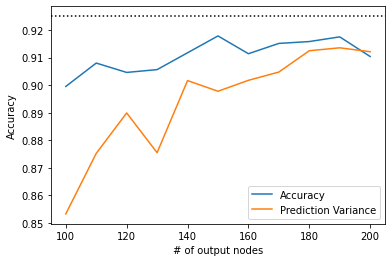

In [6]:
import matplotlib.pyplot as plt
#for i in range(len(results)):
#  print(results[i][0])
#  print(acc_list[i])
#  plt.plot(results[i][0], acc_list[i])
#plt.plot(results[i][0], var_list[i])

line1=plt.plot(component_list, component_acc)
line2 = plt.plot(component_list, component_var)
#line2=plt.plot(component_list, var_list)
plt.axhline(y=0.925, color = 'k', linestyle = ':')
plt.xlabel("# of output nodes")
plt.ylabel("Accuracy")
plt.legend((line1[0], line2[0]), ('Accuracy', 'Prediction Variance'))
#plt.legend((line1[0]), ('Accuracy'))
plt.show()

In [7]:
mid_node_list = [j for j in range(250, 375, 25)]

component_acc = []
component_var = []

for c in range(len(mid_node_list)):
    input_shape = x_train.shape[1]
    inputs = Input(shape=(input_shape))

    #Encoder
    encoded = Dense(mid_node_list[c], activation='relu')(inputs)
    encoded = Dense(190, activation='relu')(encoded)

    #Decoder
    decoded = Dense(mid_node_list[c], activation='relu')(encoded)
    decoded = Dense(input_shape)(decoded)

    #Model setup, summary and compilation
    deep_autoencoder = Model(inputs, decoded)
    deep_autoencoder.summary()
    deep_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), 
                             loss=tf.keras.losses.MeanSquaredError(), 
                             metrics=['accuracy'])

    #training the models

    batch_size = 512

    history = deep_autoencoder.fit(
        x_train,
        x_train,
        epochs=500,
        batch_size=batch_size,
        validation_split=0.2
    )

    #Encode X data
    encoder = Model(inputs, encoded)
    encoded_X_train = encoder(x_train).numpy()
    encoded_X_test = encoder(x_test).numpy()
    
    #variation looks at how the encoding/decoding affects
    y_var = deep_autoencoder.predict(x_test)
    variation = explained_variance_score(x_test, y_var, multioutput='uniform_average')
    
    accuracy = predict_y(encoded_X_train, encoded_X_test, y_train, y_test)
    component_acc.append(accuracy)
    component_var.append(variation)

Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 561)]             0         
_________________________________________________________________
dense_44 (Dense)             (None, 250)               140500    
_________________________________________________________________
dense_45 (Dense)             (None, 190)               47690     
_________________________________________________________________
dense_46 (Dense)             (None, 250)               47750     
_________________________________________________________________
dense_47 (Dense)             (None, 561)               140811    
Total params: 376,751
Trainable params: 376,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
12/12 [==============================] - 0s 21ms/step - loss: 0.3128 - accuracy: 0.0162 - val_loss: 0

Epoch 51/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0093 - accuracy: 0.2849 - val_loss: 0.0096 - val_accuracy: 0.3256
Epoch 52/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0092 - accuracy: 0.2850 - val_loss: 0.0094 - val_accuracy: 0.3175
Epoch 53/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0092 - accuracy: 0.2855 - val_loss: 0.0097 - val_accuracy: 0.3222
Epoch 54/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0091 - accuracy: 0.2859 - val_loss: 0.0093 - val_accuracy: 0.3182
Epoch 55/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0089 - accuracy: 0.2896 - val_loss: 0.0092 - val_accuracy: 0.3086
Epoch 56/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0088 - accuracy: 0.2777 - val_loss: 0.0094 - val_accuracy: 0.3222
Epoch 57/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0088 - accuracy: 0.2893 - val_loss: 0.0090 - val_accuracy: 0.3263

12/12 [==============================] - 0s 12ms/step - loss: 0.0060 - accuracy: 0.3010 - val_loss: 0.0064 - val_accuracy: 0.2964
Epoch 109/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0060 - accuracy: 0.3073 - val_loss: 0.0067 - val_accuracy: 0.3270
Epoch 110/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0065 - accuracy: 0.2947 - val_loss: 0.0063 - val_accuracy: 0.3399
Epoch 111/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0060 - accuracy: 0.3053 - val_loss: 0.0062 - val_accuracy: 0.3141
Epoch 112/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0059 - accuracy: 0.3068 - val_loss: 0.0062 - val_accuracy: 0.2896
Epoch 113/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0058 - accuracy: 0.3112 - val_loss: 0.0062 - val_accuracy: 0.3324
Epoch 114/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0058 - accuracy: 0.3020 - val_loss: 0.0061 - val_accuracy: 0.2808
Epoch 

Epoch 165/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0053 - accuracy: 0.3029 - val_loss: 0.0053 - val_accuracy: 0.2876
Epoch 166/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0049 - accuracy: 0.3065 - val_loss: 0.0052 - val_accuracy: 0.2964
Epoch 167/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0047 - accuracy: 0.3202 - val_loss: 0.0051 - val_accuracy: 0.2624
Epoch 168/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0047 - accuracy: 0.3163 - val_loss: 0.0050 - val_accuracy: 0.3202
Epoch 169/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0047 - accuracy: 0.3289 - val_loss: 0.0050 - val_accuracy: 0.3080
Epoch 170/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0047 - accuracy: 0.3187 - val_loss: 0.0051 - val_accuracy: 0.2685
Epoch 171/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0047 - accuracy: 0.3043 - val_loss: 0.0051 - val_accuracy:

Epoch 222/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0042 - accuracy: 0.3287 - val_loss: 0.0044 - val_accuracy: 0.3290
Epoch 223/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3281 - val_loss: 0.0044 - val_accuracy: 0.3589
Epoch 224/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3389 - val_loss: 0.0044 - val_accuracy: 0.3521
Epoch 225/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3355 - val_loss: 0.0043 - val_accuracy: 0.3141
Epoch 226/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0041 - accuracy: 0.3293 - val_loss: 0.0050 - val_accuracy: 0.3508
Epoch 227/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0044 - accuracy: 0.3299 - val_loss: 0.0045 - val_accuracy: 0.3188
Epoch 228/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3165 - val_loss: 0.0043 - val_accuracy:

Epoch 279/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 0.3384 - val_loss: 0.0040 - val_accuracy: 0.3691
Epoch 280/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3372 - val_loss: 0.0041 - val_accuracy: 0.3148
Epoch 281/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3423 - val_loss: 0.0039 - val_accuracy: 0.3875
Epoch 282/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3491 - val_loss: 0.0040 - val_accuracy: 0.3603
Epoch 283/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3546 - val_loss: 0.0040 - val_accuracy: 0.3678
Epoch 284/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3461 - val_loss: 0.0039 - val_accuracy: 0.3691
Epoch 285/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3583 - val_loss: 0.0040 - val_accuracy:

Epoch 336/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3469 - val_loss: 0.0037 - val_accuracy: 0.3698
Epoch 337/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3634 - val_loss: 0.0036 - val_accuracy: 0.3882
Epoch 338/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3505 - val_loss: 0.0037 - val_accuracy: 0.3324
Epoch 339/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3602 - val_loss: 0.0037 - val_accuracy: 0.3596
Epoch 340/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3563 - val_loss: 0.0036 - val_accuracy: 0.3535
Epoch 341/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3570 - val_loss: 0.0035 - val_accuracy: 0.3161
Epoch 342/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3621 - val_loss: 0.0036 - val_accuracy:

Epoch 393/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3759 - val_loss: 0.0033 - val_accuracy: 0.3460
Epoch 394/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3673 - val_loss: 0.0035 - val_accuracy: 0.3555
Epoch 395/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3568 - val_loss: 0.0038 - val_accuracy: 0.3474
Epoch 396/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0037 - accuracy: 0.3498 - val_loss: 0.0036 - val_accuracy: 0.3678
Epoch 397/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3692 - val_loss: 0.0034 - val_accuracy: 0.3453
Epoch 398/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3699 - val_loss: 0.0033 - val_accuracy: 0.3766
Epoch 399/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 0.3779 - val_loss: 0.0033 - val_accuracy:

Epoch 450/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3796 - val_loss: 0.0032 - val_accuracy: 0.3358
Epoch 451/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3830 - val_loss: 0.0033 - val_accuracy: 0.3535
Epoch 452/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3830 - val_loss: 0.0032 - val_accuracy: 0.3657
Epoch 453/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0029 - accuracy: 0.3713 - val_loss: 0.0032 - val_accuracy: 0.3603
Epoch 454/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3786 - val_loss: 0.0031 - val_accuracy: 0.3569
Epoch 455/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3876 - val_loss: 0.0032 - val_accuracy: 0.3481
Epoch 456/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0029 - accuracy: 0.3793 - val_loss: 0.0033 - val_accuracy:

12/12 [==============================] - 0s 23ms/step - loss: 0.2982 - accuracy: 0.0631 - val_loss: 0.0834 - val_accuracy: 0.2264
Epoch 2/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0726 - accuracy: 0.1032 - val_loss: 0.0481 - val_accuracy: 0.1965
Epoch 3/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0447 - accuracy: 0.1328 - val_loss: 0.0341 - val_accuracy: 0.1373
Epoch 4/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0369 - accuracy: 0.1034 - val_loss: 0.0313 - val_accuracy: 0.1468
Epoch 5/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0341 - accuracy: 0.2325 - val_loss: 0.0293 - val_accuracy: 0.3032
Epoch 6/500
12/12 [==============================] - 0s 16ms/step - loss: 0.0315 - accuracy: 0.2218 - val_loss: 0.0271 - val_accuracy: 0.2107
Epoch 7/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0288 - accuracy: 0.1493 - val_loss: 0.0250 - val_accuracy: 0.1829
Epoch 8/500
12/12 

12/12 [==============================] - 0s 12ms/step - loss: 0.0079 - accuracy: 0.2888 - val_loss: 0.0081 - val_accuracy: 0.2515
Epoch 59/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0078 - accuracy: 0.2954 - val_loss: 0.0081 - val_accuracy: 0.2910
Epoch 60/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0079 - accuracy: 0.2866 - val_loss: 0.0088 - val_accuracy: 0.3175
Epoch 61/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0079 - accuracy: 0.2949 - val_loss: 0.0079 - val_accuracy: 0.2624
Epoch 62/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0076 - accuracy: 0.2884 - val_loss: 0.0078 - val_accuracy: 0.2658
Epoch 63/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0075 - accuracy: 0.2935 - val_loss: 0.0078 - val_accuracy: 0.3120
Epoch 64/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0074 - accuracy: 0.2968 - val_loss: 0.0078 - val_accuracy: 0.2495
Epoch 65/500

12/12 [==============================] - 0s 13ms/step - loss: 0.0053 - accuracy: 0.3294 - val_loss: 0.0057 - val_accuracy: 0.3759
Epoch 116/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0053 - accuracy: 0.3306 - val_loss: 0.0056 - val_accuracy: 0.3562
Epoch 117/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0053 - accuracy: 0.3306 - val_loss: 0.0057 - val_accuracy: 0.3596
Epoch 118/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0054 - accuracy: 0.3248 - val_loss: 0.0056 - val_accuracy: 0.3508
Epoch 119/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0052 - accuracy: 0.3282 - val_loss: 0.0056 - val_accuracy: 0.4011
Epoch 120/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0052 - accuracy: 0.3299 - val_loss: 0.0058 - val_accuracy: 0.3617
Epoch 121/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0055 - accuracy: 0.3202 - val_loss: 0.0056 - val_accuracy: 0.4004
Epoch 

Epoch 172/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0050 - accuracy: 0.2881 - val_loss: 0.0049 - val_accuracy: 0.3331
Epoch 173/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 0.3340 - val_loss: 0.0046 - val_accuracy: 0.2984
Epoch 174/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0042 - accuracy: 0.3252 - val_loss: 0.0045 - val_accuracy: 0.3433
Epoch 175/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0041 - accuracy: 0.3219 - val_loss: 0.0045 - val_accuracy: 0.3508
Epoch 176/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0043 - accuracy: 0.3202 - val_loss: 0.0046 - val_accuracy: 0.2978
Epoch 177/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 0.3342 - val_loss: 0.0045 - val_accuracy: 0.3821
Epoch 178/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 0.3301 - val_loss: 0.0045 - val_accuracy:

Epoch 229/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3417 - val_loss: 0.0039 - val_accuracy: 0.3535
Epoch 230/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0039 - accuracy: 0.3316 - val_loss: 0.0053 - val_accuracy: 0.3827
Epoch 231/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0038 - accuracy: 0.3376 - val_loss: 0.0041 - val_accuracy: 0.3032
Epoch 232/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3432 - val_loss: 0.0039 - val_accuracy: 0.3066
Epoch 233/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3488 - val_loss: 0.0039 - val_accuracy: 0.3542
Epoch 234/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3444 - val_loss: 0.0040 - val_accuracy: 0.3440
Epoch 235/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0035 - accuracy: 0.3446 - val_loss: 0.0039 - val_accuracy:

Epoch 286/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3459 - val_loss: 0.0039 - val_accuracy: 0.3372
Epoch 287/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3344 - val_loss: 0.0036 - val_accuracy: 0.3297
Epoch 288/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3510 - val_loss: 0.0036 - val_accuracy: 0.3766
Epoch 289/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3621 - val_loss: 0.0035 - val_accuracy: 0.3127
Epoch 290/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3590 - val_loss: 0.0035 - val_accuracy: 0.2712
Epoch 291/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3624 - val_loss: 0.0036 - val_accuracy: 0.2447
Epoch 292/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0032 - accuracy: 0.3342 - val_loss: 0.0038 - val_accuracy:

Epoch 343/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0032 - accuracy: 0.3437 - val_loss: 0.0034 - val_accuracy: 0.2916
Epoch 344/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3563 - val_loss: 0.0034 - val_accuracy: 0.2964
Epoch 345/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3549 - val_loss: 0.0034 - val_accuracy: 0.3528
Epoch 346/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.3759 - val_loss: 0.0033 - val_accuracy: 0.3256
Epoch 347/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3590 - val_loss: 0.0036 - val_accuracy: 0.2284
Epoch 348/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3478 - val_loss: 0.0034 - val_accuracy: 0.2597
Epoch 349/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 0.3457 - val_loss: 0.0034 - val_accuracy:

Epoch 400/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0025 - accuracy: 0.3546 - val_loss: 0.0031 - val_accuracy: 0.3698
Epoch 401/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3684 - val_loss: 0.0033 - val_accuracy: 0.3385
Epoch 402/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.3570 - val_loss: 0.0033 - val_accuracy: 0.3372
Epoch 403/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.3639 - val_loss: 0.0032 - val_accuracy: 0.2862
Epoch 404/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.3663 - val_loss: 0.0031 - val_accuracy: 0.3080
Epoch 405/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0025 - accuracy: 0.3594 - val_loss: 0.0031 - val_accuracy: 0.3018
Epoch 406/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0025 - accuracy: 0.3587 - val_loss: 0.0032 - val_accuracy:

Epoch 457/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3599 - val_loss: 0.0033 - val_accuracy: 0.2094
Epoch 458/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3456 - val_loss: 0.0030 - val_accuracy: 0.2964
Epoch 459/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3651 - val_loss: 0.0030 - val_accuracy: 0.2787
Epoch 460/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3645 - val_loss: 0.0030 - val_accuracy: 0.2481
Epoch 461/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3714 - val_loss: 0.0030 - val_accuracy: 0.3311
Epoch 462/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3597 - val_loss: 0.0034 - val_accuracy: 0.2257
Epoch 463/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.3418 - val_loss: 0.0031 - val_accuracy:

Epoch 7/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0287 - accuracy: 0.1354 - val_loss: 0.0249 - val_accuracy: 0.1366
Epoch 8/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0263 - accuracy: 0.1201 - val_loss: 0.0232 - val_accuracy: 0.1278
Epoch 9/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0245 - accuracy: 0.1270 - val_loss: 0.0222 - val_accuracy: 0.1373
Epoch 10/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0233 - accuracy: 0.1490 - val_loss: 0.0214 - val_accuracy: 0.1659
Epoch 11/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0223 - accuracy: 0.1753 - val_loss: 0.0206 - val_accuracy: 0.1801
Epoch 12/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0215 - accuracy: 0.1743 - val_loss: 0.0200 - val_accuracy: 0.1822
Epoch 13/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0207 - accuracy: 0.1837 - val_loss: 0.0193 - val_accuracy: 0.1584
Ep

12/12 [==============================] - 0s 13ms/step - loss: 0.0073 - accuracy: 0.2964 - val_loss: 0.0075 - val_accuracy: 0.3542
Epoch 65/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0072 - accuracy: 0.3165 - val_loss: 0.0076 - val_accuracy: 0.3719
Epoch 66/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0076 - accuracy: 0.2878 - val_loss: 0.0076 - val_accuracy: 0.3521
Epoch 67/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0072 - accuracy: 0.3036 - val_loss: 0.0073 - val_accuracy: 0.3052
Epoch 68/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0070 - accuracy: 0.3094 - val_loss: 0.0072 - val_accuracy: 0.3270
Epoch 69/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0070 - accuracy: 0.3037 - val_loss: 0.0074 - val_accuracy: 0.3644
Epoch 70/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0070 - accuracy: 0.3102 - val_loss: 0.0073 - val_accuracy: 0.3311
Epoch 71/500

12/12 [==============================] - 0s 14ms/step - loss: 0.0051 - accuracy: 0.3155 - val_loss: 0.0054 - val_accuracy: 0.3814
Epoch 122/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0052 - accuracy: 0.3182 - val_loss: 0.0056 - val_accuracy: 0.3338
Epoch 123/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0051 - accuracy: 0.3182 - val_loss: 0.0054 - val_accuracy: 0.3433
Epoch 124/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0050 - accuracy: 0.3194 - val_loss: 0.0052 - val_accuracy: 0.3576
Epoch 125/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0049 - accuracy: 0.3219 - val_loss: 0.0053 - val_accuracy: 0.3290
Epoch 126/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0051 - accuracy: 0.3058 - val_loss: 0.0055 - val_accuracy: 0.3766
Epoch 127/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0050 - accuracy: 0.3299 - val_loss: 0.0052 - val_accuracy: 0.3385
Epoch 

Epoch 178/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 0.3306 - val_loss: 0.0044 - val_accuracy: 0.2950
Epoch 179/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0040 - accuracy: 0.3344 - val_loss: 0.0044 - val_accuracy: 0.3331
Epoch 180/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0040 - accuracy: 0.3430 - val_loss: 0.0043 - val_accuracy: 0.3114
Epoch 181/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0040 - accuracy: 0.3318 - val_loss: 0.0044 - val_accuracy: 0.3474
Epoch 182/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0046 - accuracy: 0.3337 - val_loss: 0.0046 - val_accuracy: 0.2923
Epoch 183/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0042 - accuracy: 0.3153 - val_loss: 0.0045 - val_accuracy: 0.3399
Epoch 184/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0040 - accuracy: 0.3286 - val_loss: 0.0043 - val_accuracy:

Epoch 235/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0035 - accuracy: 0.3327 - val_loss: 0.0038 - val_accuracy: 0.3440
Epoch 236/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0035 - accuracy: 0.3415 - val_loss: 0.0039 - val_accuracy: 0.2685
Epoch 237/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0035 - accuracy: 0.3378 - val_loss: 0.0039 - val_accuracy: 0.3188
Epoch 238/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3447 - val_loss: 0.0038 - val_accuracy: 0.2760
Epoch 239/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0035 - accuracy: 0.3323 - val_loss: 0.0040 - val_accuracy: 0.2787
Epoch 240/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0035 - accuracy: 0.3241 - val_loss: 0.0038 - val_accuracy: 0.2971
Epoch 241/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3388 - val_loss: 0.0039 - val_accuracy:

Epoch 292/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0032 - accuracy: 0.3515 - val_loss: 0.0034 - val_accuracy: 0.3433
Epoch 293/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3560 - val_loss: 0.0035 - val_accuracy: 0.3222
Epoch 294/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3427 - val_loss: 0.0036 - val_accuracy: 0.3671
Epoch 295/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3541 - val_loss: 0.0034 - val_accuracy: 0.3487
Epoch 296/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3549 - val_loss: 0.0034 - val_accuracy: 0.3365
Epoch 297/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3544 - val_loss: 0.0035 - val_accuracy: 0.2638
Epoch 298/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0035 - accuracy: 0.3389 - val_loss: 0.0036 - val_accuracy:

Epoch 349/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.3733 - val_loss: 0.0032 - val_accuracy: 0.2964
Epoch 350/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3478 - val_loss: 0.0035 - val_accuracy: 0.3215
Epoch 351/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3568 - val_loss: 0.0032 - val_accuracy: 0.3229
Epoch 352/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3735 - val_loss: 0.0031 - val_accuracy: 0.3290
Epoch 353/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.3796 - val_loss: 0.0031 - val_accuracy: 0.3589
Epoch 354/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3752 - val_loss: 0.0033 - val_accuracy: 0.3304
Epoch 355/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3568 - val_loss: 0.0032 - val_accuracy:

12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3864 - val_loss: 0.0030 - val_accuracy: 0.3542
Epoch 406/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3634 - val_loss: 0.0037 - val_accuracy: 0.3270
Epoch 407/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3641 - val_loss: 0.0030 - val_accuracy: 0.3630
Epoch 408/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3811 - val_loss: 0.0029 - val_accuracy: 0.3304
Epoch 409/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3825 - val_loss: 0.0029 - val_accuracy: 0.4133
Epoch 410/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0032 - accuracy: 0.3680 - val_loss: 0.0039 - val_accuracy: 0.2699
Epoch 411/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3590 - val_loss: 0.0032 - val_accuracy: 0.3848
Epoch 

Epoch 462/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3626 - val_loss: 0.0028 - val_accuracy: 0.4174
Epoch 463/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3998 - val_loss: 0.0028 - val_accuracy: 0.3664
Epoch 464/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3905 - val_loss: 0.0028 - val_accuracy: 0.4018
Epoch 465/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3867 - val_loss: 0.0031 - val_accuracy: 0.3338
Epoch 466/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.3573 - val_loss: 0.0029 - val_accuracy: 0.3902
Epoch 467/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3787 - val_loss: 0.0029 - val_accuracy: 0.3882
Epoch 468/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3745 - val_loss: 0.0028 - val_accuracy:

Epoch 12/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0208 - accuracy: 0.1820 - val_loss: 0.0195 - val_accuracy: 0.2719
Epoch 13/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0199 - accuracy: 0.1755 - val_loss: 0.0187 - val_accuracy: 0.2678
Epoch 14/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0190 - accuracy: 0.1852 - val_loss: 0.0179 - val_accuracy: 0.2175
Epoch 15/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0182 - accuracy: 0.1898 - val_loss: 0.0172 - val_accuracy: 0.2257
Epoch 16/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0173 - accuracy: 0.1946 - val_loss: 0.0167 - val_accuracy: 0.2441
Epoch 17/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0167 - accuracy: 0.2015 - val_loss: 0.0158 - val_accuracy: 0.2651
Epoch 18/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0158 - accuracy: 0.2138 - val_loss: 0.0152 - val_accuracy: 0.2712

12/12 [==============================] - 0s 14ms/step - loss: 0.0069 - accuracy: 0.2888 - val_loss: 0.0072 - val_accuracy: 0.3345
Epoch 70/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0067 - accuracy: 0.3003 - val_loss: 0.0069 - val_accuracy: 0.3358
Epoch 71/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0065 - accuracy: 0.3061 - val_loss: 0.0068 - val_accuracy: 0.3277
Epoch 72/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0064 - accuracy: 0.3071 - val_loss: 0.0067 - val_accuracy: 0.2923
Epoch 73/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0072 - accuracy: 0.2964 - val_loss: 0.0071 - val_accuracy: 0.3943
Epoch 74/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0067 - accuracy: 0.2991 - val_loss: 0.0069 - val_accuracy: 0.3148
Epoch 75/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0064 - accuracy: 0.3061 - val_loss: 0.0067 - val_accuracy: 0.3487
Epoch 76/500

12/12 [==============================] - 0s 14ms/step - loss: 0.0046 - accuracy: 0.3226 - val_loss: 0.0050 - val_accuracy: 0.4024
Epoch 127/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0046 - accuracy: 0.3296 - val_loss: 0.0049 - val_accuracy: 0.3753
Epoch 128/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0045 - accuracy: 0.3313 - val_loss: 0.0051 - val_accuracy: 0.3134
Epoch 129/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0051 - accuracy: 0.3078 - val_loss: 0.0051 - val_accuracy: 0.3365
Epoch 130/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0046 - accuracy: 0.3211 - val_loss: 0.0048 - val_accuracy: 0.3521
Epoch 131/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0044 - accuracy: 0.3374 - val_loss: 0.0048 - val_accuracy: 0.3814
Epoch 132/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0044 - accuracy: 0.3393 - val_loss: 0.0048 - val_accuracy: 0.3127
Epoch 

12/12 [==============================] - 0s 14ms/step - loss: 0.0036 - accuracy: 0.3383 - val_loss: 0.0040 - val_accuracy: 0.3732
Epoch 183/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0037 - accuracy: 0.3466 - val_loss: 0.0041 - val_accuracy: 0.3712
Epoch 184/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0040 - accuracy: 0.3413 - val_loss: 0.0042 - val_accuracy: 0.3290
Epoch 185/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0037 - accuracy: 0.3328 - val_loss: 0.0040 - val_accuracy: 0.3161
Epoch 186/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0036 - accuracy: 0.3534 - val_loss: 0.0040 - val_accuracy: 0.3494
Epoch 187/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0036 - accuracy: 0.3417 - val_loss: 0.0041 - val_accuracy: 0.3399
Epoch 188/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0038 - accuracy: 0.3502 - val_loss: 0.0042 - val_accuracy: 0.4106
Epoch 

Epoch 239/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0034 - accuracy: 0.3544 - val_loss: 0.0036 - val_accuracy: 0.3589
Epoch 240/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0031 - accuracy: 0.3519 - val_loss: 0.0035 - val_accuracy: 0.3202
Epoch 241/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0031 - accuracy: 0.3624 - val_loss: 0.0036 - val_accuracy: 0.3148
Epoch 242/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0034 - accuracy: 0.3464 - val_loss: 0.0036 - val_accuracy: 0.3644
Epoch 243/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0032 - accuracy: 0.3639 - val_loss: 0.0035 - val_accuracy: 0.3705
Epoch 244/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3519 - val_loss: 0.0035 - val_accuracy: 0.3712
Epoch 245/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0031 - accuracy: 0.3633 - val_loss: 0.0036 - val_accuracy:

Epoch 296/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0029 - accuracy: 0.3537 - val_loss: 0.0038 - val_accuracy: 0.3644
Epoch 297/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 0.3539 - val_loss: 0.0032 - val_accuracy: 0.3134
Epoch 298/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0028 - accuracy: 0.3488 - val_loss: 0.0032 - val_accuracy: 0.3678
Epoch 299/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0027 - accuracy: 0.3541 - val_loss: 0.0031 - val_accuracy: 0.3834
Epoch 300/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.3786 - val_loss: 0.0031 - val_accuracy: 0.3664
Epoch 301/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 0.3580 - val_loss: 0.0037 - val_accuracy: 0.4038
Epoch 302/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0029 - accuracy: 0.3599 - val_loss: 0.0032 - val_accuracy:

Epoch 353/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0028 - accuracy: 0.3493 - val_loss: 0.0034 - val_accuracy: 0.3311
Epoch 354/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3374 - val_loss: 0.0030 - val_accuracy: 0.3861
Epoch 355/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0025 - accuracy: 0.3573 - val_loss: 0.0029 - val_accuracy: 0.3460
Epoch 356/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0025 - accuracy: 0.3702 - val_loss: 0.0029 - val_accuracy: 0.3963
Epoch 357/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0025 - accuracy: 0.3741 - val_loss: 0.0029 - val_accuracy: 0.3161
Epoch 358/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0026 - accuracy: 0.3507 - val_loss: 0.0032 - val_accuracy: 0.3997
Epoch 359/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0027 - accuracy: 0.3541 - val_loss: 0.0029 - val_accuracy:

12/12 [==============================] - 0s 14ms/step - loss: 0.0023 - accuracy: 0.3701 - val_loss: 0.0027 - val_accuracy: 0.3807
Epoch 410/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0023 - accuracy: 0.3619 - val_loss: 0.0027 - val_accuracy: 0.3875
Epoch 411/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0023 - accuracy: 0.3605 - val_loss: 0.0029 - val_accuracy: 0.3780
Epoch 412/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0024 - accuracy: 0.3611 - val_loss: 0.0028 - val_accuracy: 0.3515
Epoch 413/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 0.3636 - val_loss: 0.0027 - val_accuracy: 0.3637
Epoch 414/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0023 - accuracy: 0.3641 - val_loss: 0.0029 - val_accuracy: 0.3970
Epoch 415/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0025 - accuracy: 0.3566 - val_loss: 0.0028 - val_accuracy: 0.3603
Epoch 

Epoch 466/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0026 - accuracy: 0.3599 - val_loss: 0.0029 - val_accuracy: 0.3440
Epoch 467/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0023 - accuracy: 0.3592 - val_loss: 0.0026 - val_accuracy: 0.3868
Epoch 468/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0021 - accuracy: 0.3633 - val_loss: 0.0026 - val_accuracy: 0.4385
Epoch 469/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0021 - accuracy: 0.3723 - val_loss: 0.0026 - val_accuracy: 0.3671
Epoch 470/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0023 - accuracy: 0.3663 - val_loss: 0.0029 - val_accuracy: 0.3868
Epoch 471/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0022 - accuracy: 0.3495 - val_loss: 0.0026 - val_accuracy: 0.3759
Epoch 472/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0021 - accuracy: 0.3621 - val_loss: 0.0025 - val_accuracy:

Epoch 16/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0168 - accuracy: 0.2301 - val_loss: 0.0164 - val_accuracy: 0.1863
Epoch 17/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0163 - accuracy: 0.2333 - val_loss: 0.0156 - val_accuracy: 0.2019
Epoch 18/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0156 - accuracy: 0.2393 - val_loss: 0.0152 - val_accuracy: 0.2305
Epoch 19/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0151 - accuracy: 0.2349 - val_loss: 0.0163 - val_accuracy: 0.1801
Epoch 20/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0149 - accuracy: 0.2435 - val_loss: 0.0144 - val_accuracy: 0.1958
Epoch 21/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0140 - accuracy: 0.2485 - val_loss: 0.0140 - val_accuracy: 0.2243
Epoch 22/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0135 - accuracy: 0.2408 - val_loss: 0.0135 - val_accuracy: 0.2386

Epoch 73/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0061 - accuracy: 0.2889 - val_loss: 0.0069 - val_accuracy: 0.2923
Epoch 74/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0063 - accuracy: 0.2874 - val_loss: 0.0065 - val_accuracy: 0.2984
Epoch 75/500
12/12 [==============================] - 0s 16ms/step - loss: 0.0060 - accuracy: 0.2971 - val_loss: 0.0066 - val_accuracy: 0.3379
Epoch 76/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0060 - accuracy: 0.3083 - val_loss: 0.0064 - val_accuracy: 0.3188
Epoch 77/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0059 - accuracy: 0.2974 - val_loss: 0.0067 - val_accuracy: 0.3453
Epoch 78/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0060 - accuracy: 0.3003 - val_loss: 0.0063 - val_accuracy: 0.3358
Epoch 79/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0058 - accuracy: 0.3005 - val_loss: 0.0064 - val_accuracy: 0.3358

12/12 [==============================] - 0s 14ms/step - loss: 0.0045 - accuracy: 0.3218 - val_loss: 0.0052 - val_accuracy: 0.3685
Epoch 131/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0045 - accuracy: 0.3165 - val_loss: 0.0048 - val_accuracy: 0.3719
Epoch 132/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0043 - accuracy: 0.3230 - val_loss: 0.0048 - val_accuracy: 0.3576
Epoch 133/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0042 - accuracy: 0.3332 - val_loss: 0.0047 - val_accuracy: 0.3651
Epoch 134/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0044 - accuracy: 0.3153 - val_loss: 0.0052 - val_accuracy: 0.3236
Epoch 135/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0049 - accuracy: 0.3100 - val_loss: 0.0050 - val_accuracy: 0.3732
Epoch 136/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0043 - accuracy: 0.3209 - val_loss: 0.0047 - val_accuracy: 0.3182
Epoch 

Epoch 187/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0036 - accuracy: 0.3349 - val_loss: 0.0040 - val_accuracy: 0.3263
Epoch 188/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0035 - accuracy: 0.3400 - val_loss: 0.0040 - val_accuracy: 0.4126
Epoch 189/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0035 - accuracy: 0.3429 - val_loss: 0.0039 - val_accuracy: 0.3215
Epoch 190/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0034 - accuracy: 0.3429 - val_loss: 0.0039 - val_accuracy: 0.3589
Epoch 191/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0038 - accuracy: 0.3276 - val_loss: 0.0049 - val_accuracy: 0.3141
Epoch 192/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0039 - accuracy: 0.3058 - val_loss: 0.0040 - val_accuracy: 0.3243
Epoch 193/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0035 - accuracy: 0.3310 - val_loss: 0.0039 - val_accuracy:

12/12 [==============================] - 0s 14ms/step - loss: 0.0031 - accuracy: 0.3580 - val_loss: 0.0035 - val_accuracy: 0.3821
Epoch 244/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 0.3526 - val_loss: 0.0035 - val_accuracy: 0.4126
Epoch 245/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0031 - accuracy: 0.3594 - val_loss: 0.0034 - val_accuracy: 0.3902
Epoch 246/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 0.3607 - val_loss: 0.0037 - val_accuracy: 0.3494
Epoch 247/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0034 - accuracy: 0.3668 - val_loss: 0.0035 - val_accuracy: 0.3800
Epoch 248/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 0.3469 - val_loss: 0.0034 - val_accuracy: 0.4337
Epoch 249/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 0.3629 - val_loss: 0.0035 - val_accuracy: 0.3732
Epoch 

Epoch 300/500
12/12 [==============================] - 0s 16ms/step - loss: 0.0027 - accuracy: 0.3759 - val_loss: 0.0031 - val_accuracy: 0.3583
Epoch 301/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0027 - accuracy: 0.3769 - val_loss: 0.0032 - val_accuracy: 0.2971
Epoch 302/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0029 - accuracy: 0.3760 - val_loss: 0.0032 - val_accuracy: 0.3929
Epoch 303/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0027 - accuracy: 0.3859 - val_loss: 0.0032 - val_accuracy: 0.3399
Epoch 304/500
12/12 [==============================] - 0s 22ms/step - loss: 0.0028 - accuracy: 0.3609 - val_loss: 0.0034 - val_accuracy: 0.4262
Epoch 305/500
12/12 [==============================] - 0s 18ms/step - loss: 0.0027 - accuracy: 0.3668 - val_loss: 0.0031 - val_accuracy: 0.3889
Epoch 306/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0027 - accuracy: 0.3845 - val_loss: 0.0033 - val_accuracy:

12/12 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 0.3672 - val_loss: 0.0032 - val_accuracy: 0.4908
Epoch 357/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0026 - accuracy: 0.3764 - val_loss: 0.0030 - val_accuracy: 0.4154
Epoch 358/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0024 - accuracy: 0.3855 - val_loss: 0.0029 - val_accuracy: 0.3861
Epoch 359/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0024 - accuracy: 0.3930 - val_loss: 0.0029 - val_accuracy: 0.4038
Epoch 360/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0026 - accuracy: 0.3830 - val_loss: 0.0032 - val_accuracy: 0.3719
Epoch 361/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0025 - accuracy: 0.3638 - val_loss: 0.0029 - val_accuracy: 0.4344
Epoch 362/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0025 - accuracy: 0.3861 - val_loss: 0.0035 - val_accuracy: 0.3984
Epoch 

Epoch 413/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0023 - accuracy: 0.4014 - val_loss: 0.0033 - val_accuracy: 0.4256
Epoch 414/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0026 - accuracy: 0.3791 - val_loss: 0.0029 - val_accuracy: 0.3433
Epoch 415/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0023 - accuracy: 0.3884 - val_loss: 0.0027 - val_accuracy: 0.4480
Epoch 416/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0022 - accuracy: 0.4020 - val_loss: 0.0027 - val_accuracy: 0.4160
Epoch 417/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0022 - accuracy: 0.4010 - val_loss: 0.0027 - val_accuracy: 0.3481
Epoch 418/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0023 - accuracy: 0.3697 - val_loss: 0.0029 - val_accuracy: 0.4052
Epoch 419/500
12/12 [==============================] - 0s 16ms/step - loss: 0.0024 - accuracy: 0.3850 - val_loss: 0.0027 - val_accuracy:

Epoch 470/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0021 - accuracy: 0.3925 - val_loss: 0.0026 - val_accuracy: 0.4405
Epoch 471/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0021 - accuracy: 0.3901 - val_loss: 0.0026 - val_accuracy: 0.4188
Epoch 472/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0021 - accuracy: 0.4077 - val_loss: 0.0026 - val_accuracy: 0.4568
Epoch 473/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0022 - accuracy: 0.3954 - val_loss: 0.0029 - val_accuracy: 0.3997
Epoch 474/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0022 - accuracy: 0.3888 - val_loss: 0.0026 - val_accuracy: 0.3148
Epoch 475/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0021 - accuracy: 0.3964 - val_loss: 0.0026 - val_accuracy: 0.3555
Epoch 476/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0021 - accuracy: 0.3908 - val_loss: 0.0026 - val_accuracy:

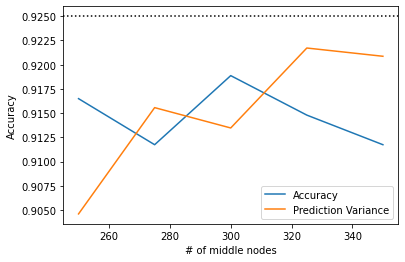

In [8]:
line1=plt.plot(mid_node_list, component_acc)
line2 = plt.plot(mid_node_list, component_var)
#line2=plt.plot(component_list, var_list)
plt.axhline(y=0.925, color = 'k', linestyle = ':')
plt.xlabel("# of middle nodes")
plt.ylabel("Accuracy")
plt.legend((line1[0], line2[0]), ('Accuracy', 'Prediction Variance'))
#plt.legend((line1[0]), ('Accuracy'))
plt.show()

In [9]:
component_list = [i for i in range(130, 210, 10)]
component_acc = []
component_var = []

for c in range(len(component_list)):
    input_shape = x_train.shape[1]
    inputs = Input(shape=(input_shape))

    #Encoder
    encoded = Dense(300, activation='relu')(inputs)
    encoded = Dense(component_list[c], activation='relu')(encoded)

    #Decoder
    decoded = Dense(300, activation='relu')(encoded)
    decoded = Dense(input_shape)(decoded)

    #Model setup, summary and compilation
    deep_autoencoder = Model(inputs, decoded)
    deep_autoencoder.summary()
    deep_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), 
                             loss=tf.keras.losses.MeanSquaredError(), 
                             metrics=['accuracy'])

    #training the models

    batch_size = 512

    history = deep_autoencoder.fit(
        x_train,
        x_train,
        epochs=500,
        batch_size=batch_size,
        validation_split=0.2
    )

    #Encode X data
    encoder = Model(inputs, encoded)
    encoded_X_train = encoder(x_train).numpy()
    encoded_X_test = encoder(x_test).numpy()
    
    #variation looks at how the encoding/decoding affects
    y_var = deep_autoencoder.predict(x_test)
    variation = explained_variance_score(x_test, y_var, multioutput='uniform_average')
    
    accuracy = predict_y(encoded_X_train, encoded_X_test, y_train, y_test)
    component_acc.append(accuracy)
    component_var.append(variation)

Model: "functional_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 561)]             0         
_________________________________________________________________
dense_64 (Dense)             (None, 300)               168600    
_________________________________________________________________
dense_65 (Dense)             (None, 130)               39130     
_________________________________________________________________
dense_66 (Dense)             (None, 300)               39300     
_________________________________________________________________
dense_67 (Dense)             (None, 561)               168861    
Total params: 415,891
Trainable params: 415,891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
12/12 [==============================] - 0s 22ms/step - loss: 0.2916 - accuracy: 0.0279 - val_loss: 0

12/12 [==============================] - 0s 12ms/step - loss: 0.0087 - accuracy: 0.2847 - val_loss: 0.0092 - val_accuracy: 0.3032
Epoch 52/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0086 - accuracy: 0.2867 - val_loss: 0.0090 - val_accuracy: 0.2733
Epoch 53/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0084 - accuracy: 0.2874 - val_loss: 0.0089 - val_accuracy: 0.2529
Epoch 54/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0083 - accuracy: 0.2900 - val_loss: 0.0090 - val_accuracy: 0.3229
Epoch 55/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0085 - accuracy: 0.2816 - val_loss: 0.0088 - val_accuracy: 0.3351
Epoch 56/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0082 - accuracy: 0.2920 - val_loss: 0.0086 - val_accuracy: 0.3236
Epoch 57/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0081 - accuracy: 0.2889 - val_loss: 0.0086 - val_accuracy: 0.3175
Epoch 58/500

12/12 [==============================] - 0s 12ms/step - loss: 0.0058 - accuracy: 0.3182 - val_loss: 0.0063 - val_accuracy: 0.3324
Epoch 109/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0058 - accuracy: 0.3134 - val_loss: 0.0063 - val_accuracy: 0.3970
Epoch 110/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0058 - accuracy: 0.3180 - val_loss: 0.0062 - val_accuracy: 0.3583
Epoch 111/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0057 - accuracy: 0.3294 - val_loss: 0.0063 - val_accuracy: 0.4181
Epoch 112/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0058 - accuracy: 0.3061 - val_loss: 0.0064 - val_accuracy: 0.3073
Epoch 113/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0058 - accuracy: 0.3122 - val_loss: 0.0063 - val_accuracy: 0.3787
Epoch 114/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0057 - accuracy: 0.3262 - val_loss: 0.0062 - val_accuracy: 0.3379
Epoch 

Epoch 165/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0050 - accuracy: 0.3330 - val_loss: 0.0054 - val_accuracy: 0.4031
Epoch 166/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0048 - accuracy: 0.3514 - val_loss: 0.0054 - val_accuracy: 0.3841
Epoch 167/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0048 - accuracy: 0.3435 - val_loss: 0.0053 - val_accuracy: 0.3433
Epoch 168/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0047 - accuracy: 0.3519 - val_loss: 0.0053 - val_accuracy: 0.3732
Epoch 169/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0047 - accuracy: 0.3512 - val_loss: 0.0053 - val_accuracy: 0.3963
Epoch 170/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0048 - accuracy: 0.3417 - val_loss: 0.0058 - val_accuracy: 0.3807
Epoch 171/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0052 - accuracy: 0.3323 - val_loss: 0.0054 - val_accuracy:

Epoch 222/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0042 - accuracy: 0.3554 - val_loss: 0.0048 - val_accuracy: 0.3773
Epoch 223/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0042 - accuracy: 0.3585 - val_loss: 0.0048 - val_accuracy: 0.3236
Epoch 224/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 0.3502 - val_loss: 0.0048 - val_accuracy: 0.4181
Epoch 225/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0042 - accuracy: 0.3498 - val_loss: 0.0049 - val_accuracy: 0.4031
Epoch 226/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 0.3549 - val_loss: 0.0048 - val_accuracy: 0.3691
Epoch 227/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0042 - accuracy: 0.3750 - val_loss: 0.0047 - val_accuracy: 0.3807
Epoch 228/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0042 - accuracy: 0.3599 - val_loss: 0.0049 - val_accuracy:

Epoch 279/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3544 - val_loss: 0.0045 - val_accuracy: 0.3868
Epoch 280/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0038 - accuracy: 0.3498 - val_loss: 0.0044 - val_accuracy: 0.3882
Epoch 281/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0038 - accuracy: 0.3616 - val_loss: 0.0044 - val_accuracy: 0.3814
Epoch 282/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0038 - accuracy: 0.3675 - val_loss: 0.0044 - val_accuracy: 0.4215
Epoch 283/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0040 - accuracy: 0.3714 - val_loss: 0.0051 - val_accuracy: 0.3542
Epoch 284/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 0.3354 - val_loss: 0.0045 - val_accuracy: 0.3984
Epoch 285/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0038 - accuracy: 0.3583 - val_loss: 0.0044 - val_accuracy:

Epoch 336/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0037 - accuracy: 0.3544 - val_loss: 0.0043 - val_accuracy: 0.4215
Epoch 337/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3713 - val_loss: 0.0042 - val_accuracy: 0.4038
Epoch 338/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3747 - val_loss: 0.0043 - val_accuracy: 0.4324
Epoch 339/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3776 - val_loss: 0.0042 - val_accuracy: 0.4038
Epoch 340/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3828 - val_loss: 0.0042 - val_accuracy: 0.4018
Epoch 341/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0037 - accuracy: 0.3769 - val_loss: 0.0044 - val_accuracy: 0.4453
Epoch 342/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3753 - val_loss: 0.0043 - val_accuracy:

Epoch 393/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3741 - val_loss: 0.0043 - val_accuracy: 0.4140
Epoch 394/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3801 - val_loss: 0.0042 - val_accuracy: 0.4636
Epoch 395/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3827 - val_loss: 0.0041 - val_accuracy: 0.4126
Epoch 396/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3900 - val_loss: 0.0041 - val_accuracy: 0.4616
Epoch 397/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3867 - val_loss: 0.0042 - val_accuracy: 0.4099
Epoch 398/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3764 - val_loss: 0.0042 - val_accuracy: 0.4024
Epoch 399/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3925 - val_loss: 0.0043 - val_accuracy:

Epoch 450/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3949 - val_loss: 0.0040 - val_accuracy: 0.4242
Epoch 451/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3898 - val_loss: 0.0042 - val_accuracy: 0.4038
Epoch 452/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3944 - val_loss: 0.0041 - val_accuracy: 0.3671
Epoch 453/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.4007 - val_loss: 0.0041 - val_accuracy: 0.4194
Epoch 454/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3923 - val_loss: 0.0042 - val_accuracy: 0.4058
Epoch 455/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3815 - val_loss: 0.0041 - val_accuracy: 0.4677
Epoch 456/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.4099 - val_loss: 0.0041 - val_accuracy:

12/12 [==============================] - 0s 21ms/step - loss: 0.2928 - accuracy: 0.1340 - val_loss: 0.0808 - val_accuracy: 0.0184
Epoch 2/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0673 - accuracy: 0.0439 - val_loss: 0.0441 - val_accuracy: 0.3073
Epoch 3/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0424 - accuracy: 0.2446 - val_loss: 0.0338 - val_accuracy: 0.2454
Epoch 4/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0363 - accuracy: 0.1670 - val_loss: 0.0307 - val_accuracy: 0.2175
Epoch 5/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0337 - accuracy: 0.1869 - val_loss: 0.0289 - val_accuracy: 0.2461
Epoch 6/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0314 - accuracy: 0.2333 - val_loss: 0.0269 - val_accuracy: 0.2896
Epoch 7/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0289 - accuracy: 0.2262 - val_loss: 0.0248 - val_accuracy: 0.2672
Epoch 8/500
12/12 

12/12 [==============================] - 0s 12ms/step - loss: 0.0078 - accuracy: 0.3122 - val_loss: 0.0081 - val_accuracy: 0.3012
Epoch 59/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0079 - accuracy: 0.3024 - val_loss: 0.0095 - val_accuracy: 0.3358
Epoch 60/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0082 - accuracy: 0.2951 - val_loss: 0.0082 - val_accuracy: 0.3093
Epoch 61/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0077 - accuracy: 0.3116 - val_loss: 0.0080 - val_accuracy: 0.2855
Epoch 62/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0075 - accuracy: 0.3107 - val_loss: 0.0079 - val_accuracy: 0.2869
Epoch 63/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0074 - accuracy: 0.3145 - val_loss: 0.0078 - val_accuracy: 0.3406
Epoch 64/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0074 - accuracy: 0.3078 - val_loss: 0.0077 - val_accuracy: 0.3215
Epoch 65/500

12/12 [==============================] - 0s 12ms/step - loss: 0.0055 - accuracy: 0.3207 - val_loss: 0.0058 - val_accuracy: 0.3413
Epoch 116/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0055 - accuracy: 0.3337 - val_loss: 0.0059 - val_accuracy: 0.2916
Epoch 117/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0055 - accuracy: 0.3349 - val_loss: 0.0058 - val_accuracy: 0.3215
Epoch 118/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0054 - accuracy: 0.3299 - val_loss: 0.0058 - val_accuracy: 0.3549
Epoch 119/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0053 - accuracy: 0.3333 - val_loss: 0.0058 - val_accuracy: 0.3263
Epoch 120/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0054 - accuracy: 0.3211 - val_loss: 0.0060 - val_accuracy: 0.3923
Epoch 121/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0054 - accuracy: 0.3332 - val_loss: 0.0057 - val_accuracy: 0.3256
Epoch 

Epoch 172/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0046 - accuracy: 0.3321 - val_loss: 0.0049 - val_accuracy: 0.3195
Epoch 173/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0045 - accuracy: 0.3483 - val_loss: 0.0049 - val_accuracy: 0.3460
Epoch 174/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0045 - accuracy: 0.3374 - val_loss: 0.0049 - val_accuracy: 0.3549
Epoch 175/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0046 - accuracy: 0.3456 - val_loss: 0.0061 - val_accuracy: 0.2508
Epoch 176/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0050 - accuracy: 0.3121 - val_loss: 0.0051 - val_accuracy: 0.3644
Epoch 177/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0045 - accuracy: 0.3432 - val_loss: 0.0049 - val_accuracy: 0.2910
Epoch 178/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0044 - accuracy: 0.3447 - val_loss: 0.0049 - val_accuracy:

Epoch 229/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 0.3323 - val_loss: 0.0046 - val_accuracy: 0.3351
Epoch 230/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3522 - val_loss: 0.0045 - val_accuracy: 0.3793
Epoch 231/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3514 - val_loss: 0.0045 - val_accuracy: 0.3073
Epoch 232/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3473 - val_loss: 0.0045 - val_accuracy: 0.3474
Epoch 233/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3509 - val_loss: 0.0045 - val_accuracy: 0.3351
Epoch 234/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3442 - val_loss: 0.0045 - val_accuracy: 0.2760
Epoch 235/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3526 - val_loss: 0.0045 - val_accuracy:

Epoch 286/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0038 - accuracy: 0.3582 - val_loss: 0.0042 - val_accuracy: 0.3154
Epoch 287/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0037 - accuracy: 0.3570 - val_loss: 0.0042 - val_accuracy: 0.3576
Epoch 288/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3639 - val_loss: 0.0042 - val_accuracy: 0.3555
Epoch 289/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0037 - accuracy: 0.3651 - val_loss: 0.0043 - val_accuracy: 0.2583
Epoch 290/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3544 - val_loss: 0.0042 - val_accuracy: 0.2930
Epoch 291/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0037 - accuracy: 0.3500 - val_loss: 0.0042 - val_accuracy: 0.4004
Epoch 292/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3621 - val_loss: 0.0042 - val_accuracy:

Epoch 343/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3507 - val_loss: 0.0041 - val_accuracy: 0.3766
Epoch 344/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3733 - val_loss: 0.0040 - val_accuracy: 0.3569
Epoch 345/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3716 - val_loss: 0.0040 - val_accuracy: 0.3141
Epoch 346/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3476 - val_loss: 0.0041 - val_accuracy: 0.3766
Epoch 347/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3743 - val_loss: 0.0040 - val_accuracy: 0.3589
Epoch 348/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3599 - val_loss: 0.0043 - val_accuracy: 0.3834
Epoch 349/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3714 - val_loss: 0.0041 - val_accuracy:

Epoch 400/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3719 - val_loss: 0.0042 - val_accuracy: 0.3861
Epoch 401/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3684 - val_loss: 0.0039 - val_accuracy: 0.4337
Epoch 402/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3707 - val_loss: 0.0039 - val_accuracy: 0.4133
Epoch 403/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3801 - val_loss: 0.0038 - val_accuracy: 0.3549
Epoch 404/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3787 - val_loss: 0.0039 - val_accuracy: 0.3508
Epoch 405/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3679 - val_loss: 0.0041 - val_accuracy: 0.3392
Epoch 406/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3646 - val_loss: 0.0040 - val_accuracy:

Epoch 457/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3918 - val_loss: 0.0037 - val_accuracy: 0.3814
Epoch 458/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3855 - val_loss: 0.0037 - val_accuracy: 0.3637
Epoch 459/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3912 - val_loss: 0.0037 - val_accuracy: 0.3834
Epoch 460/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3714 - val_loss: 0.0039 - val_accuracy: 0.3120
Epoch 461/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3838 - val_loss: 0.0038 - val_accuracy: 0.3290
Epoch 462/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3753 - val_loss: 0.0037 - val_accuracy: 0.3739
Epoch 463/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3871 - val_loss: 0.0037 - val_accuracy:

Epoch 7/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0281 - accuracy: 0.1563 - val_loss: 0.0244 - val_accuracy: 0.1455
Epoch 8/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0256 - accuracy: 0.1412 - val_loss: 0.0229 - val_accuracy: 0.1251
Epoch 9/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0240 - accuracy: 0.1430 - val_loss: 0.0219 - val_accuracy: 0.1543
Epoch 10/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0229 - accuracy: 0.1611 - val_loss: 0.0211 - val_accuracy: 0.1795
Epoch 11/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0219 - accuracy: 0.1777 - val_loss: 0.0204 - val_accuracy: 0.2162
Epoch 12/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0210 - accuracy: 0.1801 - val_loss: 0.0196 - val_accuracy: 0.2080
Epoch 13/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0201 - accuracy: 0.1869 - val_loss: 0.0188 - val_accuracy: 0.2475
Ep

12/12 [==============================] - 0s 12ms/step - loss: 0.0075 - accuracy: 0.3017 - val_loss: 0.0079 - val_accuracy: 0.3188
Epoch 65/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0074 - accuracy: 0.3158 - val_loss: 0.0078 - val_accuracy: 0.3209
Epoch 66/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0073 - accuracy: 0.3124 - val_loss: 0.0078 - val_accuracy: 0.2910
Epoch 67/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0073 - accuracy: 0.3107 - val_loss: 0.0083 - val_accuracy: 0.3657
Epoch 68/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0075 - accuracy: 0.3097 - val_loss: 0.0078 - val_accuracy: 0.3678
Epoch 69/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0072 - accuracy: 0.3187 - val_loss: 0.0076 - val_accuracy: 0.2998
Epoch 70/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0071 - accuracy: 0.3095 - val_loss: 0.0075 - val_accuracy: 0.3610
Epoch 71/500

12/12 [==============================] - 0s 12ms/step - loss: 0.0053 - accuracy: 0.3303 - val_loss: 0.0057 - val_accuracy: 0.3474
Epoch 122/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0053 - accuracy: 0.3223 - val_loss: 0.0060 - val_accuracy: 0.2998
Epoch 123/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0056 - accuracy: 0.3100 - val_loss: 0.0059 - val_accuracy: 0.3528
Epoch 124/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0053 - accuracy: 0.3177 - val_loss: 0.0057 - val_accuracy: 0.3535
Epoch 125/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0052 - accuracy: 0.3306 - val_loss: 0.0057 - val_accuracy: 0.3249
Epoch 126/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0052 - accuracy: 0.3226 - val_loss: 0.0056 - val_accuracy: 0.3889
Epoch 127/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0051 - accuracy: 0.3306 - val_loss: 0.0056 - val_accuracy: 0.2916
Epoch 

Epoch 178/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0044 - accuracy: 0.3425 - val_loss: 0.0048 - val_accuracy: 0.3141
Epoch 179/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 0.3446 - val_loss: 0.0048 - val_accuracy: 0.3141
Epoch 180/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 0.3406 - val_loss: 0.0048 - val_accuracy: 0.2910
Epoch 181/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0045 - accuracy: 0.3284 - val_loss: 0.0050 - val_accuracy: 0.3114
Epoch 182/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0044 - accuracy: 0.3406 - val_loss: 0.0048 - val_accuracy: 0.3202
Epoch 183/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 0.3526 - val_loss: 0.0047 - val_accuracy: 0.3175
Epoch 184/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 0.3337 - val_loss: 0.0047 - val_accuracy:

Epoch 235/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0039 - accuracy: 0.3566 - val_loss: 0.0044 - val_accuracy: 0.2502
Epoch 236/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0041 - accuracy: 0.3456 - val_loss: 0.0046 - val_accuracy: 0.3148
Epoch 237/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3497 - val_loss: 0.0044 - val_accuracy: 0.2998
Epoch 238/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0038 - accuracy: 0.3580 - val_loss: 0.0044 - val_accuracy: 0.3379
Epoch 239/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0038 - accuracy: 0.3580 - val_loss: 0.0043 - val_accuracy: 0.2998
Epoch 240/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0039 - accuracy: 0.3476 - val_loss: 0.0044 - val_accuracy: 0.2923
Epoch 241/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0039 - accuracy: 0.3548 - val_loss: 0.0044 - val_accuracy:

Epoch 292/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0037 - accuracy: 0.3474 - val_loss: 0.0042 - val_accuracy: 0.2964
Epoch 293/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3486 - val_loss: 0.0040 - val_accuracy: 0.3202
Epoch 294/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3668 - val_loss: 0.0041 - val_accuracy: 0.2468
Epoch 295/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3675 - val_loss: 0.0041 - val_accuracy: 0.3236
Epoch 296/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0037 - accuracy: 0.3592 - val_loss: 0.0042 - val_accuracy: 0.2597
Epoch 297/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3383 - val_loss: 0.0041 - val_accuracy: 0.3617
Epoch 298/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3616 - val_loss: 0.0041 - val_accuracy:

Epoch 349/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3631 - val_loss: 0.0039 - val_accuracy: 0.3243
Epoch 350/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3602 - val_loss: 0.0039 - val_accuracy: 0.3154
Epoch 351/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3588 - val_loss: 0.0039 - val_accuracy: 0.3046
Epoch 352/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3702 - val_loss: 0.0039 - val_accuracy: 0.2563
Epoch 353/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3471 - val_loss: 0.0039 - val_accuracy: 0.3814
Epoch 354/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3677 - val_loss: 0.0043 - val_accuracy: 0.3508
Epoch 355/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3641 - val_loss: 0.0039 - val_accuracy:

Epoch 406/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3548 - val_loss: 0.0039 - val_accuracy: 0.3379
Epoch 407/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3612 - val_loss: 0.0037 - val_accuracy: 0.3793
Epoch 408/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0032 - accuracy: 0.3692 - val_loss: 0.0038 - val_accuracy: 0.3379
Epoch 409/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3605 - val_loss: 0.0038 - val_accuracy: 0.3725
Epoch 410/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3662 - val_loss: 0.0038 - val_accuracy: 0.3589
Epoch 411/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3531 - val_loss: 0.0038 - val_accuracy: 0.3644
Epoch 412/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3673 - val_loss: 0.0037 - val_accuracy:

Epoch 463/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3757 - val_loss: 0.0036 - val_accuracy: 0.3868
Epoch 464/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3765 - val_loss: 0.0037 - val_accuracy: 0.2923
Epoch 465/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3592 - val_loss: 0.0037 - val_accuracy: 0.3909
Epoch 466/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3517 - val_loss: 0.0037 - val_accuracy: 0.4276
Epoch 467/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3706 - val_loss: 0.0036 - val_accuracy: 0.2808
Epoch 468/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3680 - val_loss: 0.0038 - val_accuracy: 0.3569
Epoch 469/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3597 - val_loss: 0.0038 - val_accuracy:

Epoch 13/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0206 - accuracy: 0.1971 - val_loss: 0.0193 - val_accuracy: 0.2624
Epoch 14/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0198 - accuracy: 0.1923 - val_loss: 0.0185 - val_accuracy: 0.2780
Epoch 15/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0189 - accuracy: 0.2034 - val_loss: 0.0178 - val_accuracy: 0.2984
Epoch 16/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0181 - accuracy: 0.2097 - val_loss: 0.0172 - val_accuracy: 0.2665
Epoch 17/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0174 - accuracy: 0.2211 - val_loss: 0.0165 - val_accuracy: 0.2930
Epoch 18/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0167 - accuracy: 0.2349 - val_loss: 0.0160 - val_accuracy: 0.2964
Epoch 19/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0160 - accuracy: 0.2400 - val_loss: 0.0155 - val_accuracy: 0.2930

12/12 [==============================] - 0s 12ms/step - loss: 0.0074 - accuracy: 0.2823 - val_loss: 0.0077 - val_accuracy: 0.2964
Epoch 71/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0072 - accuracy: 0.2934 - val_loss: 0.0076 - val_accuracy: 0.2746
Epoch 72/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0071 - accuracy: 0.2930 - val_loss: 0.0076 - val_accuracy: 0.3018
Epoch 73/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0071 - accuracy: 0.2964 - val_loss: 0.0080 - val_accuracy: 0.2345
Epoch 74/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0072 - accuracy: 0.2866 - val_loss: 0.0076 - val_accuracy: 0.2780
Epoch 75/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0070 - accuracy: 0.2981 - val_loss: 0.0074 - val_accuracy: 0.2957
Epoch 76/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0069 - accuracy: 0.3032 - val_loss: 0.0074 - val_accuracy: 0.2407
Epoch 77/500

12/12 [==============================] - 0s 12ms/step - loss: 0.0052 - accuracy: 0.3286 - val_loss: 0.0057 - val_accuracy: 0.3909
Epoch 128/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0052 - accuracy: 0.3352 - val_loss: 0.0057 - val_accuracy: 0.2944
Epoch 129/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0052 - accuracy: 0.3296 - val_loss: 0.0060 - val_accuracy: 0.3698
Epoch 130/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0054 - accuracy: 0.3231 - val_loss: 0.0057 - val_accuracy: 0.3270
Epoch 131/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0052 - accuracy: 0.3303 - val_loss: 0.0056 - val_accuracy: 0.3413
Epoch 132/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0051 - accuracy: 0.3427 - val_loss: 0.0056 - val_accuracy: 0.3671
Epoch 133/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0051 - accuracy: 0.3352 - val_loss: 0.0057 - val_accuracy: 0.3637
Epoch 

Epoch 184/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0044 - accuracy: 0.3568 - val_loss: 0.0049 - val_accuracy: 0.3562
Epoch 185/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 0.3520 - val_loss: 0.0048 - val_accuracy: 0.3487
Epoch 186/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0043 - accuracy: 0.3529 - val_loss: 0.0049 - val_accuracy: 0.3351
Epoch 187/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0044 - accuracy: 0.3364 - val_loss: 0.0050 - val_accuracy: 0.3338
Epoch 188/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0044 - accuracy: 0.3388 - val_loss: 0.0048 - val_accuracy: 0.4004
Epoch 189/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 0.3444 - val_loss: 0.0048 - val_accuracy: 0.3732
Epoch 190/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 0.3558 - val_loss: 0.0048 - val_accuracy:

Epoch 241/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3617 - val_loss: 0.0046 - val_accuracy: 0.3583
Epoch 242/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0041 - accuracy: 0.3512 - val_loss: 0.0044 - val_accuracy: 0.3889
Epoch 243/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0039 - accuracy: 0.3549 - val_loss: 0.0044 - val_accuracy: 0.3467
Epoch 244/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0039 - accuracy: 0.3531 - val_loss: 0.0044 - val_accuracy: 0.4004
Epoch 245/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0039 - accuracy: 0.3568 - val_loss: 0.0044 - val_accuracy: 0.3984
Epoch 246/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0039 - accuracy: 0.3582 - val_loss: 0.0044 - val_accuracy: 0.3433
Epoch 247/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3566 - val_loss: 0.0047 - val_accuracy:

Epoch 298/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0039 - accuracy: 0.3498 - val_loss: 0.0043 - val_accuracy: 0.3685
Epoch 299/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3556 - val_loss: 0.0042 - val_accuracy: 0.3793
Epoch 300/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3597 - val_loss: 0.0042 - val_accuracy: 0.4222
Epoch 301/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3634 - val_loss: 0.0041 - val_accuracy: 0.3916
Epoch 302/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3622 - val_loss: 0.0041 - val_accuracy: 0.3807
Epoch 303/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0037 - accuracy: 0.3594 - val_loss: 0.0047 - val_accuracy: 0.4154
Epoch 304/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0038 - accuracy: 0.3539 - val_loss: 0.0042 - val_accuracy:

Epoch 355/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3827 - val_loss: 0.0040 - val_accuracy: 0.3685
Epoch 356/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3706 - val_loss: 0.0040 - val_accuracy: 0.4174
Epoch 357/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3673 - val_loss: 0.0042 - val_accuracy: 0.3848
Epoch 358/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 0.3813 - val_loss: 0.0039 - val_accuracy: 0.4303
Epoch 359/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3779 - val_loss: 0.0039 - val_accuracy: 0.4147
Epoch 360/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3861 - val_loss: 0.0039 - val_accuracy: 0.3807
Epoch 361/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3781 - val_loss: 0.0039 - val_accuracy:

Epoch 412/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3723 - val_loss: 0.0041 - val_accuracy: 0.3909
Epoch 413/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3682 - val_loss: 0.0038 - val_accuracy: 0.4799
Epoch 414/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3794 - val_loss: 0.0038 - val_accuracy: 0.4160
Epoch 415/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3912 - val_loss: 0.0037 - val_accuracy: 0.4269
Epoch 416/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3811 - val_loss: 0.0040 - val_accuracy: 0.3916
Epoch 417/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3730 - val_loss: 0.0038 - val_accuracy: 0.3780
Epoch 418/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 0.3842 - val_loss: 0.0039 - val_accuracy:

Epoch 469/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3893 - val_loss: 0.0036 - val_accuracy: 0.4460
Epoch 470/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3861 - val_loss: 0.0037 - val_accuracy: 0.4317
Epoch 471/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.3821 - val_loss: 0.0039 - val_accuracy: 0.3331
Epoch 472/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3823 - val_loss: 0.0037 - val_accuracy: 0.4038
Epoch 473/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3935 - val_loss: 0.0036 - val_accuracy: 0.4446
Epoch 474/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.3842 - val_loss: 0.0036 - val_accuracy: 0.4392
Epoch 475/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 0.4007 - val_loss: 0.0036 - val_accuracy:

Epoch 19/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0157 - accuracy: 0.2252 - val_loss: 0.0150 - val_accuracy: 0.2726
Epoch 20/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0149 - accuracy: 0.2286 - val_loss: 0.0146 - val_accuracy: 0.2624
Epoch 21/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0144 - accuracy: 0.2270 - val_loss: 0.0141 - val_accuracy: 0.3025
Epoch 22/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0143 - accuracy: 0.2389 - val_loss: 0.0142 - val_accuracy: 0.2441
Epoch 23/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0138 - accuracy: 0.2412 - val_loss: 0.0135 - val_accuracy: 0.2903
Epoch 24/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0132 - accuracy: 0.2532 - val_loss: 0.0131 - val_accuracy: 0.2644
Epoch 25/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0128 - accuracy: 0.2537 - val_loss: 0.0128 - val_accuracy: 0.3046

12/12 [==============================] - 0s 14ms/step - loss: 0.0067 - accuracy: 0.2978 - val_loss: 0.0071 - val_accuracy: 0.3426
Epoch 77/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0066 - accuracy: 0.2934 - val_loss: 0.0071 - val_accuracy: 0.3834
Epoch 78/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0065 - accuracy: 0.3049 - val_loss: 0.0070 - val_accuracy: 0.3977
Epoch 79/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0066 - accuracy: 0.2976 - val_loss: 0.0072 - val_accuracy: 0.3399
Epoch 80/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0067 - accuracy: 0.2991 - val_loss: 0.0070 - val_accuracy: 0.3535
Epoch 81/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0064 - accuracy: 0.3048 - val_loss: 0.0068 - val_accuracy: 0.3562
Epoch 82/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0064 - accuracy: 0.3044 - val_loss: 0.0070 - val_accuracy: 0.3141
Epoch 83/500

12/12 [==============================] - 0s 13ms/step - loss: 0.0049 - accuracy: 0.3359 - val_loss: 0.0054 - val_accuracy: 0.3657
Epoch 134/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0049 - accuracy: 0.3463 - val_loss: 0.0055 - val_accuracy: 0.3249
Epoch 135/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0050 - accuracy: 0.3417 - val_loss: 0.0053 - val_accuracy: 0.3372
Epoch 136/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0048 - accuracy: 0.3418 - val_loss: 0.0053 - val_accuracy: 0.3120
Epoch 137/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0048 - accuracy: 0.3381 - val_loss: 0.0052 - val_accuracy: 0.3283
Epoch 138/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0048 - accuracy: 0.3381 - val_loss: 0.0053 - val_accuracy: 0.3610
Epoch 139/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0050 - accuracy: 0.3389 - val_loss: 0.0067 - val_accuracy: 0.3651
Epoch 

Epoch 190/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0047 - accuracy: 0.3284 - val_loss: 0.0046 - val_accuracy: 0.2855
Epoch 191/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0042 - accuracy: 0.3406 - val_loss: 0.0046 - val_accuracy: 0.3916
Epoch 192/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 0.3514 - val_loss: 0.0045 - val_accuracy: 0.2842
Epoch 193/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 0.3554 - val_loss: 0.0046 - val_accuracy: 0.3861
Epoch 194/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0044 - accuracy: 0.3514 - val_loss: 0.0046 - val_accuracy: 0.3345
Epoch 195/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 0.3423 - val_loss: 0.0045 - val_accuracy: 0.2937
Epoch 196/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0040 - accuracy: 0.3423 - val_loss: 0.0044 - val_accuracy:

Epoch 247/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3507 - val_loss: 0.0042 - val_accuracy: 0.3467
Epoch 248/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0038 - accuracy: 0.3580 - val_loss: 0.0042 - val_accuracy: 0.3222
Epoch 249/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3519 - val_loss: 0.0041 - val_accuracy: 0.3182
Epoch 250/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0036 - accuracy: 0.3481 - val_loss: 0.0041 - val_accuracy: 0.3406
Epoch 251/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.3529 - val_loss: 0.0041 - val_accuracy: 0.3766
Epoch 252/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0036 - accuracy: 0.3588 - val_loss: 0.0040 - val_accuracy: 0.3413
Epoch 253/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0037 - accuracy: 0.3590 - val_loss: 0.0044 - val_accuracy:

Epoch 304/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.3502 - val_loss: 0.0037 - val_accuracy: 0.3603
Epoch 305/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 0.3621 - val_loss: 0.0038 - val_accuracy: 0.3977
Epoch 306/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0035 - accuracy: 0.3741 - val_loss: 0.0040 - val_accuracy: 0.3501
Epoch 307/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3597 - val_loss: 0.0038 - val_accuracy: 0.3222
Epoch 308/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.3641 - val_loss: 0.0037 - val_accuracy: 0.3161
Epoch 309/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.3728 - val_loss: 0.0038 - val_accuracy: 0.3426
Epoch 310/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3605 - val_loss: 0.0040 - val_accuracy:

Epoch 361/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3755 - val_loss: 0.0036 - val_accuracy: 0.3249
Epoch 362/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3597 - val_loss: 0.0037 - val_accuracy: 0.4731
Epoch 363/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.3457 - val_loss: 0.0038 - val_accuracy: 0.3426
Epoch 364/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3711 - val_loss: 0.0036 - val_accuracy: 0.3610
Epoch 365/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3827 - val_loss: 0.0035 - val_accuracy: 0.3161
Epoch 366/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3753 - val_loss: 0.0036 - val_accuracy: 0.3215
Epoch 367/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3825 - val_loss: 0.0036 - val_accuracy:

Epoch 418/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3973 - val_loss: 0.0034 - val_accuracy: 0.3950
Epoch 419/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3779 - val_loss: 0.0034 - val_accuracy: 0.3916
Epoch 420/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3849 - val_loss: 0.0037 - val_accuracy: 0.2835
Epoch 421/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0031 - accuracy: 0.3604 - val_loss: 0.0036 - val_accuracy: 0.3399
Epoch 422/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3738 - val_loss: 0.0034 - val_accuracy: 0.3562
Epoch 423/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3883 - val_loss: 0.0034 - val_accuracy: 0.3249
Epoch 424/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3883 - val_loss: 0.0034 - val_accuracy:

Epoch 475/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0027 - accuracy: 0.3963 - val_loss: 0.0033 - val_accuracy: 0.3351
Epoch 476/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3840 - val_loss: 0.0035 - val_accuracy: 0.3562
Epoch 477/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3704 - val_loss: 0.0034 - val_accuracy: 0.3800
Epoch 478/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3721 - val_loss: 0.0033 - val_accuracy: 0.3705
Epoch 479/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.4017 - val_loss: 0.0033 - val_accuracy: 0.3882
Epoch 480/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.3961 - val_loss: 0.0033 - val_accuracy: 0.2923
Epoch 481/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3850 - val_loss: 0.0036 - val_accuracy:

Epoch 25/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0131 - accuracy: 0.2437 - val_loss: 0.0130 - val_accuracy: 0.2828
Epoch 26/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0127 - accuracy: 0.2563 - val_loss: 0.0129 - val_accuracy: 0.2848
Epoch 27/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0125 - accuracy: 0.2515 - val_loss: 0.0124 - val_accuracy: 0.3168
Epoch 28/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0121 - accuracy: 0.2568 - val_loss: 0.0123 - val_accuracy: 0.2570
Epoch 29/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0122 - accuracy: 0.2580 - val_loss: 0.0121 - val_accuracy: 0.2944
Epoch 30/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0116 - accuracy: 0.2495 - val_loss: 0.0116 - val_accuracy: 0.3256
Epoch 31/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0113 - accuracy: 0.2668 - val_loss: 0.0114 - val_accuracy: 0.2950

12/12 [==============================] - 0s 13ms/step - loss: 0.0063 - accuracy: 0.2844 - val_loss: 0.0067 - val_accuracy: 0.3168
Epoch 83/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0063 - accuracy: 0.2910 - val_loss: 0.0066 - val_accuracy: 0.2746
Epoch 84/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0063 - accuracy: 0.2895 - val_loss: 0.0074 - val_accuracy: 0.2624
Epoch 85/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0070 - accuracy: 0.2889 - val_loss: 0.0067 - val_accuracy: 0.2441
Epoch 86/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0063 - accuracy: 0.2813 - val_loss: 0.0065 - val_accuracy: 0.3175
Epoch 87/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0061 - accuracy: 0.2869 - val_loss: 0.0064 - val_accuracy: 0.3406
Epoch 88/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0061 - accuracy: 0.2934 - val_loss: 0.0063 - val_accuracy: 0.2937
Epoch 89/500

12/12 [==============================] - 0s 13ms/step - loss: 0.0047 - accuracy: 0.3105 - val_loss: 0.0051 - val_accuracy: 0.2542
Epoch 140/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0047 - accuracy: 0.3180 - val_loss: 0.0053 - val_accuracy: 0.2230
Epoch 141/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0047 - accuracy: 0.3077 - val_loss: 0.0050 - val_accuracy: 0.2896
Epoch 142/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0046 - accuracy: 0.3172 - val_loss: 0.0050 - val_accuracy: 0.2277
Epoch 143/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0046 - accuracy: 0.3160 - val_loss: 0.0049 - val_accuracy: 0.2583
Epoch 144/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0047 - accuracy: 0.3160 - val_loss: 0.0056 - val_accuracy: 0.2651
Epoch 145/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0049 - accuracy: 0.3022 - val_loss: 0.0050 - val_accuracy: 0.2828
Epoch 

Epoch 196/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0039 - accuracy: 0.3480 - val_loss: 0.0042 - val_accuracy: 0.2012
Epoch 197/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0038 - accuracy: 0.3383 - val_loss: 0.0042 - val_accuracy: 0.3086
Epoch 198/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0038 - accuracy: 0.3553 - val_loss: 0.0045 - val_accuracy: 0.2046
Epoch 199/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0041 - accuracy: 0.3442 - val_loss: 0.0043 - val_accuracy: 0.2651
Epoch 200/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0038 - accuracy: 0.3359 - val_loss: 0.0041 - val_accuracy: 0.2903
Epoch 201/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0037 - accuracy: 0.3464 - val_loss: 0.0042 - val_accuracy: 0.2692
Epoch 202/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0039 - accuracy: 0.3503 - val_loss: 0.0043 - val_accuracy:

Epoch 253/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3614 - val_loss: 0.0038 - val_accuracy: 0.3453
Epoch 254/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3740 - val_loss: 0.0037 - val_accuracy: 0.2522
Epoch 255/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.3585 - val_loss: 0.0036 - val_accuracy: 0.3168
Epoch 256/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.3675 - val_loss: 0.0038 - val_accuracy: 0.2774
Epoch 257/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3502 - val_loss: 0.0038 - val_accuracy: 0.3046
Epoch 258/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0035 - accuracy: 0.3498 - val_loss: 0.0043 - val_accuracy: 0.3025
Epoch 259/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3384 - val_loss: 0.0037 - val_accuracy:

Epoch 310/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3730 - val_loss: 0.0040 - val_accuracy: 0.3617
Epoch 311/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3543 - val_loss: 0.0035 - val_accuracy: 0.3107
Epoch 312/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3692 - val_loss: 0.0034 - val_accuracy: 0.3651
Epoch 313/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3847 - val_loss: 0.0033 - val_accuracy: 0.2923
Epoch 314/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3707 - val_loss: 0.0039 - val_accuracy: 0.3283
Epoch 315/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.3490 - val_loss: 0.0035 - val_accuracy: 0.3800
Epoch 316/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3837 - val_loss: 0.0034 - val_accuracy:

Epoch 367/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3738 - val_loss: 0.0032 - val_accuracy: 0.2930
Epoch 368/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3738 - val_loss: 0.0032 - val_accuracy: 0.3549
Epoch 369/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3827 - val_loss: 0.0031 - val_accuracy: 0.2957
Epoch 370/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.3886 - val_loss: 0.0031 - val_accuracy: 0.2760
Epoch 371/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.3893 - val_loss: 0.0031 - val_accuracy: 0.2998
Epoch 372/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3874 - val_loss: 0.0034 - val_accuracy: 0.3175
Epoch 373/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3451 - val_loss: 0.0033 - val_accuracy:

Epoch 424/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3740 - val_loss: 0.0030 - val_accuracy: 0.3549
Epoch 425/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3755 - val_loss: 0.0030 - val_accuracy: 0.3821
Epoch 426/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3786 - val_loss: 0.0031 - val_accuracy: 0.3481
Epoch 427/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3747 - val_loss: 0.0030 - val_accuracy: 0.4079
Epoch 428/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3878 - val_loss: 0.0030 - val_accuracy: 0.3685
Epoch 429/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3929 - val_loss: 0.0029 - val_accuracy: 0.3916
Epoch 430/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0027 - accuracy: 0.3747 - val_loss: 0.0034 - val_accuracy:

Epoch 481/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0024 - accuracy: 0.3949 - val_loss: 0.0028 - val_accuracy: 0.3481
Epoch 482/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.4002 - val_loss: 0.0028 - val_accuracy: 0.3827
Epoch 483/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0026 - accuracy: 0.3747 - val_loss: 0.0034 - val_accuracy: 0.3392
Epoch 484/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3680 - val_loss: 0.0032 - val_accuracy: 0.3148
Epoch 485/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3833 - val_loss: 0.0028 - val_accuracy: 0.3487
Epoch 486/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3884 - val_loss: 0.0028 - val_accuracy: 0.3861
Epoch 487/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.4073 - val_loss: 0.0028 - val_accuracy:

Epoch 31/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0112 - accuracy: 0.2585 - val_loss: 0.0113 - val_accuracy: 0.2903
Epoch 32/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0109 - accuracy: 0.2704 - val_loss: 0.0109 - val_accuracy: 0.2746
Epoch 33/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0106 - accuracy: 0.2651 - val_loss: 0.0107 - val_accuracy: 0.3209
Epoch 34/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0104 - accuracy: 0.2741 - val_loss: 0.0105 - val_accuracy: 0.2712
Epoch 35/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0102 - accuracy: 0.2760 - val_loss: 0.0104 - val_accuracy: 0.2998
Epoch 36/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0105 - accuracy: 0.2682 - val_loss: 0.0106 - val_accuracy: 0.2998
Epoch 37/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0100 - accuracy: 0.2772 - val_loss: 0.0101 - val_accuracy: 0.2658

12/12 [==============================] - 0s 13ms/step - loss: 0.0060 - accuracy: 0.3165 - val_loss: 0.0062 - val_accuracy: 0.2298
Epoch 89/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0058 - accuracy: 0.3128 - val_loss: 0.0061 - val_accuracy: 0.2944
Epoch 90/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0058 - accuracy: 0.3303 - val_loss: 0.0061 - val_accuracy: 0.2916
Epoch 91/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0058 - accuracy: 0.3128 - val_loss: 0.0061 - val_accuracy: 0.2597
Epoch 92/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0060 - accuracy: 0.3128 - val_loss: 0.0068 - val_accuracy: 0.2345
Epoch 93/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0059 - accuracy: 0.3141 - val_loss: 0.0061 - val_accuracy: 0.2733
Epoch 94/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0057 - accuracy: 0.3122 - val_loss: 0.0060 - val_accuracy: 0.2862
Epoch 95/500

12/12 [==============================] - 0s 13ms/step - loss: 0.0044 - accuracy: 0.3435 - val_loss: 0.0049 - val_accuracy: 0.3005
Epoch 146/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0044 - accuracy: 0.3520 - val_loss: 0.0047 - val_accuracy: 0.2964
Epoch 147/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0043 - accuracy: 0.3582 - val_loss: 0.0046 - val_accuracy: 0.3379
Epoch 148/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0042 - accuracy: 0.3641 - val_loss: 0.0046 - val_accuracy: 0.2991
Epoch 149/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0048 - accuracy: 0.3296 - val_loss: 0.0051 - val_accuracy: 0.3331
Epoch 150/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0045 - accuracy: 0.3272 - val_loss: 0.0047 - val_accuracy: 0.2991
Epoch 151/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0042 - accuracy: 0.3549 - val_loss: 0.0046 - val_accuracy: 0.3066
Epoch 

Epoch 202/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0036 - accuracy: 0.3611 - val_loss: 0.0039 - val_accuracy: 0.3535
Epoch 203/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0035 - accuracy: 0.3641 - val_loss: 0.0040 - val_accuracy: 0.2984
Epoch 204/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0039 - accuracy: 0.3485 - val_loss: 0.0041 - val_accuracy: 0.3413
Epoch 205/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0036 - accuracy: 0.3464 - val_loss: 0.0040 - val_accuracy: 0.3168
Epoch 206/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0035 - accuracy: 0.3561 - val_loss: 0.0040 - val_accuracy: 0.3358
Epoch 207/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0036 - accuracy: 0.3633 - val_loss: 0.0041 - val_accuracy: 0.2957
Epoch 208/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0036 - accuracy: 0.3512 - val_loss: 0.0041 - val_accuracy:

Epoch 259/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0032 - accuracy: 0.3464 - val_loss: 0.0036 - val_accuracy: 0.3188
Epoch 260/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3566 - val_loss: 0.0035 - val_accuracy: 0.3494
Epoch 261/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3682 - val_loss: 0.0038 - val_accuracy: 0.3311
Epoch 262/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.3561 - val_loss: 0.0036 - val_accuracy: 0.3759
Epoch 263/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3687 - val_loss: 0.0035 - val_accuracy: 0.3093
Epoch 264/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3614 - val_loss: 0.0035 - val_accuracy: 0.3583
Epoch 265/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3565 - val_loss: 0.0035 - val_accuracy:

Epoch 316/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3718 - val_loss: 0.0033 - val_accuracy: 0.3691
Epoch 317/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3668 - val_loss: 0.0032 - val_accuracy: 0.3467
Epoch 318/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.3648 - val_loss: 0.0032 - val_accuracy: 0.3277
Epoch 319/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3420 - val_loss: 0.0037 - val_accuracy: 0.4466
Epoch 320/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3639 - val_loss: 0.0032 - val_accuracy: 0.3515
Epoch 321/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.3690 - val_loss: 0.0032 - val_accuracy: 0.3365
Epoch 322/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3662 - val_loss: 0.0036 - val_accuracy:

Epoch 373/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3779 - val_loss: 0.0030 - val_accuracy: 0.3385
Epoch 374/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3735 - val_loss: 0.0032 - val_accuracy: 0.4024
Epoch 375/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3624 - val_loss: 0.0031 - val_accuracy: 0.3243
Epoch 376/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3706 - val_loss: 0.0030 - val_accuracy: 0.3066
Epoch 377/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3827 - val_loss: 0.0030 - val_accuracy: 0.3467
Epoch 378/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3777 - val_loss: 0.0030 - val_accuracy: 0.3800
Epoch 379/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3813 - val_loss: 0.0030 - val_accuracy:

Epoch 430/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3847 - val_loss: 0.0030 - val_accuracy: 0.2665
Epoch 431/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3735 - val_loss: 0.0028 - val_accuracy: 0.3399
Epoch 432/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 0.3864 - val_loss: 0.0028 - val_accuracy: 0.3467
Epoch 433/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3750 - val_loss: 0.0031 - val_accuracy: 0.3487
Epoch 434/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3765 - val_loss: 0.0028 - val_accuracy: 0.3766
Epoch 435/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 0.3833 - val_loss: 0.0028 - val_accuracy: 0.4018
Epoch 436/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0024 - accuracy: 0.3808 - val_loss: 0.0033 - val_accuracy:

Epoch 487/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3833 - val_loss: 0.0028 - val_accuracy: 0.2903
Epoch 488/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 0.3847 - val_loss: 0.0027 - val_accuracy: 0.3263
Epoch 489/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0022 - accuracy: 0.3913 - val_loss: 0.0026 - val_accuracy: 0.3304
Epoch 490/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0022 - accuracy: 0.3840 - val_loss: 0.0027 - val_accuracy: 0.3861
Epoch 491/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3884 - val_loss: 0.0029 - val_accuracy: 0.3617
Epoch 492/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 0.3735 - val_loss: 0.0026 - val_accuracy: 0.3379
Epoch 493/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0022 - accuracy: 0.3861 - val_loss: 0.0026 - val_accuracy:

Epoch 37/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0097 - accuracy: 0.2731 - val_loss: 0.0101 - val_accuracy: 0.2869
Epoch 38/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0095 - accuracy: 0.2690 - val_loss: 0.0098 - val_accuracy: 0.2780
Epoch 39/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0094 - accuracy: 0.2738 - val_loss: 0.0098 - val_accuracy: 0.2998
Epoch 40/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0092 - accuracy: 0.2781 - val_loss: 0.0095 - val_accuracy: 0.3161
Epoch 41/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0092 - accuracy: 0.2724 - val_loss: 0.0109 - val_accuracy: 0.2930
Epoch 42/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0097 - accuracy: 0.2682 - val_loss: 0.0096 - val_accuracy: 0.3052
Epoch 43/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0089 - accuracy: 0.2740 - val_loss: 0.0092 - val_accuracy: 0.3134

12/12 [==============================] - 0s 13ms/step - loss: 0.0055 - accuracy: 0.3107 - val_loss: 0.0059 - val_accuracy: 0.3787
Epoch 95/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0055 - accuracy: 0.3090 - val_loss: 0.0060 - val_accuracy: 0.3385
Epoch 96/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0055 - accuracy: 0.2995 - val_loss: 0.0060 - val_accuracy: 0.3460
Epoch 97/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0056 - accuracy: 0.3046 - val_loss: 0.0061 - val_accuracy: 0.2978
Epoch 98/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0055 - accuracy: 0.3048 - val_loss: 0.0059 - val_accuracy: 0.3719
Epoch 99/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0054 - accuracy: 0.3156 - val_loss: 0.0057 - val_accuracy: 0.3283
Epoch 100/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0054 - accuracy: 0.3111 - val_loss: 0.0061 - val_accuracy: 0.3440
Epoch 101/5

12/12 [==============================] - 0s 13ms/step - loss: 0.0042 - accuracy: 0.3361 - val_loss: 0.0046 - val_accuracy: 0.2937
Epoch 152/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 0.3294 - val_loss: 0.0045 - val_accuracy: 0.3046
Epoch 153/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 0.3354 - val_loss: 0.0047 - val_accuracy: 0.3188
Epoch 154/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0046 - accuracy: 0.3374 - val_loss: 0.0047 - val_accuracy: 0.2787
Epoch 155/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0042 - accuracy: 0.3330 - val_loss: 0.0046 - val_accuracy: 0.3419
Epoch 156/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 0.3383 - val_loss: 0.0045 - val_accuracy: 0.3576
Epoch 157/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 0.3352 - val_loss: 0.0045 - val_accuracy: 0.3440
Epoch 

Epoch 208/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0038 - accuracy: 0.3253 - val_loss: 0.0039 - val_accuracy: 0.2957
Epoch 209/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0035 - accuracy: 0.3357 - val_loss: 0.0039 - val_accuracy: 0.3018
Epoch 210/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3481 - val_loss: 0.0039 - val_accuracy: 0.2984
Epoch 211/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3573 - val_loss: 0.0041 - val_accuracy: 0.2835
Epoch 212/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0036 - accuracy: 0.3347 - val_loss: 0.0038 - val_accuracy: 0.3603
Epoch 213/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0034 - accuracy: 0.3471 - val_loss: 0.0039 - val_accuracy: 0.3311
Epoch 214/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3391 - val_loss: 0.0038 - val_accuracy:

Epoch 265/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3456 - val_loss: 0.0034 - val_accuracy: 0.3175
Epoch 266/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3464 - val_loss: 0.0034 - val_accuracy: 0.3093
Epoch 267/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3388 - val_loss: 0.0035 - val_accuracy: 0.3331
Epoch 268/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3315 - val_loss: 0.0038 - val_accuracy: 0.3161
Epoch 269/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3478 - val_loss: 0.0034 - val_accuracy: 0.2869
Epoch 270/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3434 - val_loss: 0.0034 - val_accuracy: 0.3161
Epoch 271/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.3515 - val_loss: 0.0038 - val_accuracy:

Epoch 322/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3558 - val_loss: 0.0031 - val_accuracy: 0.2529
Epoch 323/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3362 - val_loss: 0.0031 - val_accuracy: 0.3549
Epoch 324/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3532 - val_loss: 0.0030 - val_accuracy: 0.3175
Epoch 325/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3440 - val_loss: 0.0031 - val_accuracy: 0.3562
Epoch 326/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3284 - val_loss: 0.0031 - val_accuracy: 0.2610
Epoch 327/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3497 - val_loss: 0.0030 - val_accuracy: 0.3175
Epoch 328/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3599 - val_loss: 0.0030 - val_accuracy:

Epoch 379/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3490 - val_loss: 0.0028 - val_accuracy: 0.3555
Epoch 380/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3500 - val_loss: 0.0032 - val_accuracy: 0.3671
Epoch 381/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.3459 - val_loss: 0.0029 - val_accuracy: 0.3589
Epoch 382/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3558 - val_loss: 0.0028 - val_accuracy: 0.3413
Epoch 383/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3553 - val_loss: 0.0030 - val_accuracy: 0.3365
Epoch 384/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3500 - val_loss: 0.0030 - val_accuracy: 0.3120
Epoch 385/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3622 - val_loss: 0.0028 - val_accuracy:

Epoch 436/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 0.3543 - val_loss: 0.0026 - val_accuracy: 0.2712
Epoch 437/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0022 - accuracy: 0.3571 - val_loss: 0.0026 - val_accuracy: 0.2930
Epoch 438/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 0.3391 - val_loss: 0.0026 - val_accuracy: 0.3120
Epoch 439/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0022 - accuracy: 0.3617 - val_loss: 0.0026 - val_accuracy: 0.3148
Epoch 440/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 0.3597 - val_loss: 0.0028 - val_accuracy: 0.2971
Epoch 441/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0022 - accuracy: 0.3565 - val_loss: 0.0026 - val_accuracy: 0.3277
Epoch 442/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0022 - accuracy: 0.3548 - val_loss: 0.0026 - val_accuracy:

Epoch 493/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3573 - val_loss: 0.0026 - val_accuracy: 0.3433
Epoch 494/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0021 - accuracy: 0.3687 - val_loss: 0.0024 - val_accuracy: 0.3596
Epoch 495/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3767 - val_loss: 0.0024 - val_accuracy: 0.3419
Epoch 496/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3781 - val_loss: 0.0024 - val_accuracy: 0.3474
Epoch 497/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0021 - accuracy: 0.3784 - val_loss: 0.0031 - val_accuracy: 0.3501
Epoch 498/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3490 - val_loss: 0.0026 - val_accuracy: 0.3447
Epoch 499/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0021 - accuracy: 0.3682 - val_loss: 0.0024 - val_accuracy:

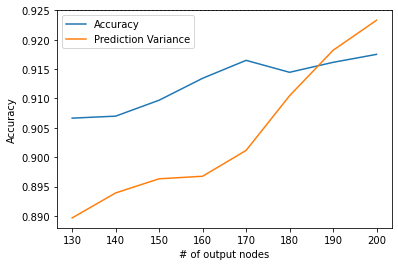

In [10]:
line1=plt.plot(component_list, component_acc)
line2 = plt.plot(component_list, component_var)
#line2=plt.plot(component_list, var_list)
plt.axhline(y=0.925, color = 'k', linestyle = ':')
plt.xlabel("# of output nodes")
plt.ylabel("Accuracy")
plt.legend((line1[0], line2[0]), ('Accuracy', 'Prediction Variance'))
#plt.legend((line1[0]), ('Accuracy'))
plt.show()

Using the following settings:

Batch size = 512
Epochs = 500
Middle nodes = 300
Output nodes = 190

In [11]:
input_shape = x_train.shape[1]
inputs = Input(shape=(input_shape))

#Encoder
encoded = Dense(300, activation='relu')(inputs)
encoded = Dense(190, activation='relu')(encoded)

#Decoder
decoded = Dense(300, activation='relu')(encoded)
decoded = Dense(input_shape)(decoded)

#Model setup, summary and compilation
deep_autoencoder = Model(inputs, decoded)
deep_autoencoder.summary()
deep_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), 
        loss=tf.keras.losses.MeanSquaredError(), 
        metrics=['accuracy'])

#training the models

batch_size = 512

history = deep_autoencoder.fit(
        x_train,
        x_train,
        epochs=500,
        batch_size=batch_size,
        validation_split=0.2
    )

#Encode X data
encoder = Model(inputs, encoded)
encoded_X_train = encoder(x_train).numpy()
encoded_X_test = encoder(x_test).numpy()
    
#variation looks at how the encoding/decoding affects
y_var = deep_autoencoder.predict(x_test)
variation = explained_variance_score(x_test, y_var, multioutput='uniform_average')
    
accuracy = predict_y(encoded_X_train, encoded_X_test, y_train, y_test)
print("Activation: relu, optimizer: Adam")
print("Accuracy: %.6f Prediction Variance:%.6f" % (accuracy, variation))
#component_acc.append(accuracy)
#component_var.append(variation)

Model: "functional_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 561)]             0         
_________________________________________________________________
dense_96 (Dense)             (None, 300)               168600    
_________________________________________________________________
dense_97 (Dense)             (None, 190)               57190     
_________________________________________________________________
dense_98 (Dense)             (None, 300)               57300     
_________________________________________________________________
dense_99 (Dense)             (None, 561)               168861    
Total params: 451,951
Trainable params: 451,951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
12/12 [==============================] - 0s 22ms/step - loss: 0.2611 - accuracy: 0.0252 - val_loss: 0

12/12 [==============================] - 0s 13ms/step - loss: 0.0083 - accuracy: 0.2769 - val_loss: 0.0088 - val_accuracy: 0.2502
Epoch 52/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0081 - accuracy: 0.2879 - val_loss: 0.0084 - val_accuracy: 0.2658
Epoch 53/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0079 - accuracy: 0.2769 - val_loss: 0.0083 - val_accuracy: 0.2067
Epoch 54/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0078 - accuracy: 0.2799 - val_loss: 0.0083 - val_accuracy: 0.2583
Epoch 55/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0083 - accuracy: 0.2724 - val_loss: 0.0082 - val_accuracy: 0.2896
Epoch 56/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0079 - accuracy: 0.2835 - val_loss: 0.0082 - val_accuracy: 0.2447
Epoch 57/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0076 - accuracy: 0.2765 - val_loss: 0.0080 - val_accuracy: 0.2590
Epoch 58/500

12/12 [==============================] - 0s 13ms/step - loss: 0.0053 - accuracy: 0.3202 - val_loss: 0.0056 - val_accuracy: 0.2794
Epoch 109/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0054 - accuracy: 0.3134 - val_loss: 0.0055 - val_accuracy: 0.2794
Epoch 110/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0052 - accuracy: 0.3213 - val_loss: 0.0054 - val_accuracy: 0.2828
Epoch 111/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0051 - accuracy: 0.3109 - val_loss: 0.0055 - val_accuracy: 0.2726
Epoch 112/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0052 - accuracy: 0.3192 - val_loss: 0.0055 - val_accuracy: 0.2271
Epoch 113/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0051 - accuracy: 0.3187 - val_loss: 0.0054 - val_accuracy: 0.2950
Epoch 114/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0052 - accuracy: 0.3204 - val_loss: 0.0061 - val_accuracy: 0.3304
Epoch 

Epoch 165/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0040 - accuracy: 0.3372 - val_loss: 0.0043 - val_accuracy: 0.3215
Epoch 166/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0040 - accuracy: 0.3413 - val_loss: 0.0044 - val_accuracy: 0.2590
Epoch 167/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0042 - accuracy: 0.3264 - val_loss: 0.0046 - val_accuracy: 0.2828
Epoch 168/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 0.3320 - val_loss: 0.0043 - val_accuracy: 0.2828
Epoch 169/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0039 - accuracy: 0.3456 - val_loss: 0.0042 - val_accuracy: 0.3399
Epoch 170/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0039 - accuracy: 0.3432 - val_loss: 0.0043 - val_accuracy: 0.2740
Epoch 171/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0044 - accuracy: 0.3221 - val_loss: 0.0048 - val_accuracy:

Epoch 222/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.3509 - val_loss: 0.0037 - val_accuracy: 0.2726
Epoch 223/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.3656 - val_loss: 0.0037 - val_accuracy: 0.3270
Epoch 224/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3515 - val_loss: 0.0037 - val_accuracy: 0.2644
Epoch 225/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.3560 - val_loss: 0.0037 - val_accuracy: 0.2971
Epoch 226/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0036 - accuracy: 0.3287 - val_loss: 0.0039 - val_accuracy: 0.3440
Epoch 227/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.3449 - val_loss: 0.0037 - val_accuracy: 0.3426
Epoch 228/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.3713 - val_loss: 0.0036 - val_accuracy:

Epoch 279/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3605 - val_loss: 0.0033 - val_accuracy: 0.2937
Epoch 280/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3663 - val_loss: 0.0033 - val_accuracy: 0.3324
Epoch 281/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 0.3597 - val_loss: 0.0042 - val_accuracy: 0.2672
Epoch 282/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0036 - accuracy: 0.3282 - val_loss: 0.0033 - val_accuracy: 0.2923
Epoch 283/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3568 - val_loss: 0.0033 - val_accuracy: 0.3923
Epoch 284/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3607 - val_loss: 0.0032 - val_accuracy: 0.3215
Epoch 285/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.3811 - val_loss: 0.0038 - val_accuracy:

Epoch 336/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3743 - val_loss: 0.0035 - val_accuracy: 0.2454
Epoch 337/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.3616 - val_loss: 0.0030 - val_accuracy: 0.3637
Epoch 338/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3747 - val_loss: 0.0030 - val_accuracy: 0.3508
Epoch 339/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3794 - val_loss: 0.0029 - val_accuracy: 0.2597
Epoch 340/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.3711 - val_loss: 0.0031 - val_accuracy: 0.2957
Epoch 341/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3464 - val_loss: 0.0031 - val_accuracy: 0.3127
Epoch 342/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.3765 - val_loss: 0.0030 - val_accuracy:

Epoch 393/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3862 - val_loss: 0.0028 - val_accuracy: 0.3617
Epoch 394/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3684 - val_loss: 0.0028 - val_accuracy: 0.3977
Epoch 395/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3787 - val_loss: 0.0027 - val_accuracy: 0.3678
Epoch 396/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3784 - val_loss: 0.0030 - val_accuracy: 0.3610
Epoch 397/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.3602 - val_loss: 0.0031 - val_accuracy: 0.2835
Epoch 398/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3648 - val_loss: 0.0028 - val_accuracy: 0.3678
Epoch 399/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.3864 - val_loss: 0.0027 - val_accuracy:

Epoch 450/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 0.3699 - val_loss: 0.0027 - val_accuracy: 0.3617
Epoch 451/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 0.3862 - val_loss: 0.0029 - val_accuracy: 0.4045
Epoch 452/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 0.3762 - val_loss: 0.0027 - val_accuracy: 0.3481
Epoch 453/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 0.3821 - val_loss: 0.0027 - val_accuracy: 0.3882
Epoch 454/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0022 - accuracy: 0.3765 - val_loss: 0.0027 - val_accuracy: 0.3467
Epoch 455/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 0.3815 - val_loss: 0.0027 - val_accuracy: 0.3120
Epoch 456/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 0.3532 - val_loss: 0.0029 - val_accuracy:

In [12]:
print("Activation: relu, optimizer: Adam")
print("Accuracy: %.6f Prediction Variance:%.6f" % (accuracy, variation))

Activation: relu, optimizer: Adam
Accuracy: 0.920570 Prediction Variance:0.918815


In [13]:
#Model setup, summary and compilation
AE_SGD = Model(inputs, decoded)
AE_SGD.summary()
AE_SGD.compile(optimizer=tf.keras.optimizers.SGD(), 
        loss=tf.keras.losses.MeanSquaredError(), 
        metrics=['accuracy'])

history = AE_SGD.fit(
        x_train,
        x_train,
        epochs=500,
        batch_size=batch_size,
        validation_split=0.2
    )

#Encode X data
encoder = Model(inputs, encoded)
encoded_X_train = encoder(x_train).numpy()
encoded_X_test = encoder(x_test).numpy()
    
#variation looks at how the encoding/decoding affects
y_var = AE_SGD.predict(x_test)
variation = explained_variance_score(x_test, y_var, multioutput='uniform_average')
    
accuracy = predict_y(encoded_X_train, encoded_X_test, y_train, y_test)

Model: "functional_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 561)]             0         
_________________________________________________________________
dense_96 (Dense)             (None, 300)               168600    
_________________________________________________________________
dense_97 (Dense)             (None, 190)               57190     
_________________________________________________________________
dense_98 (Dense)             (None, 300)               57300     
_________________________________________________________________
dense_99 (Dense)             (None, 561)               168861    
Total params: 451,951
Trainable params: 451,951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
12/12 [==============================] - 0s 22ms/step - loss: 0.0021 - accuracy: 0.3980 - val_loss: 

12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.4058 - val_loss: 0.0025 - val_accuracy: 0.4147
Epoch 52/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.4056 - val_loss: 0.0025 - val_accuracy: 0.4147
Epoch 53/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.4053 - val_loss: 0.0025 - val_accuracy: 0.4147
Epoch 54/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.4043 - val_loss: 0.0025 - val_accuracy: 0.4140
Epoch 55/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.4051 - val_loss: 0.0025 - val_accuracy: 0.4140
Epoch 56/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.4043 - val_loss: 0.0025 - val_accuracy: 0.4140
Epoch 57/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.4043 - val_loss: 0.0025 - val_accuracy: 0.4140
Epoch 58/500

12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.4005 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 109/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3998 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 110/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.4002 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 111/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.4002 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 112/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.4003 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 113/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3998 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 114/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3997 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 

Epoch 165/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3974 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 166/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3983 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 167/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3980 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 168/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3981 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 169/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3980 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 170/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3981 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 171/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3980 - val_loss: 0.0025 - val_accuracy:

Epoch 222/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3974 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 223/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3974 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 224/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3973 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 225/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3973 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 226/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3974 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 227/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3978 - val_loss: 0.0025 - val_accuracy: 0.4072
Epoch 228/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3973 - val_loss: 0.0025 - val_accuracy:

Epoch 279/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3993 - val_loss: 0.0025 - val_accuracy: 0.4065
Epoch 280/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3998 - val_loss: 0.0025 - val_accuracy: 0.4065
Epoch 281/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3998 - val_loss: 0.0025 - val_accuracy: 0.4065
Epoch 282/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3995 - val_loss: 0.0025 - val_accuracy: 0.4065
Epoch 283/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.4000 - val_loss: 0.0025 - val_accuracy: 0.4065
Epoch 284/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3995 - val_loss: 0.0025 - val_accuracy: 0.4065
Epoch 285/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3993 - val_loss: 0.0025 - val_accuracy:

Epoch 336/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3997 - val_loss: 0.0025 - val_accuracy: 0.4045
Epoch 337/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3995 - val_loss: 0.0025 - val_accuracy: 0.4045
Epoch 338/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3997 - val_loss: 0.0025 - val_accuracy: 0.4045
Epoch 339/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.4000 - val_loss: 0.0025 - val_accuracy: 0.4045
Epoch 340/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3997 - val_loss: 0.0025 - val_accuracy: 0.4045
Epoch 341/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3997 - val_loss: 0.0025 - val_accuracy: 0.4045
Epoch 342/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3997 - val_loss: 0.0025 - val_accuracy:

Epoch 393/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3995 - val_loss: 0.0025 - val_accuracy: 0.4045
Epoch 394/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3995 - val_loss: 0.0025 - val_accuracy: 0.4045
Epoch 395/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3991 - val_loss: 0.0025 - val_accuracy: 0.4045
Epoch 396/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0020 - accuracy: 0.3997 - val_loss: 0.0025 - val_accuracy: 0.4045
Epoch 397/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.3998 - val_loss: 0.0025 - val_accuracy: 0.4045
Epoch 398/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3997 - val_loss: 0.0025 - val_accuracy: 0.4052
Epoch 399/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3998 - val_loss: 0.0025 - val_accuracy:

Epoch 450/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3995 - val_loss: 0.0025 - val_accuracy: 0.4052
Epoch 451/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3993 - val_loss: 0.0025 - val_accuracy: 0.4052
Epoch 452/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3990 - val_loss: 0.0025 - val_accuracy: 0.4052
Epoch 453/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3995 - val_loss: 0.0025 - val_accuracy: 0.4045
Epoch 454/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3995 - val_loss: 0.0025 - val_accuracy: 0.4045
Epoch 455/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3998 - val_loss: 0.0025 - val_accuracy: 0.4045
Epoch 456/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 0.3991 - val_loss: 0.0025 - val_accuracy:

In [14]:
print("Activation: relu, optimizer: SGD")
print("Accuracy: %.6f Prediction Variance:%.6f" % (accuracy, variation))

Activation: relu, optimizer: SGD
Accuracy: 0.920231 Prediction Variance:0.919264


In [15]:
#Model setup, summary and compilation
AE_RMS = Model(inputs, decoded)
AE_RMS.summary()
AE_RMS.compile(optimizer=tf.keras.optimizers.RMSprop(), 
        loss=tf.keras.losses.MeanSquaredError(), 
        metrics=['accuracy'])

history = AE_RMS.fit(
        x_train,
        x_train,
        epochs=500,
        batch_size=batch_size,
        validation_split=0.2
    )

#Encode X data
encoder = Model(inputs, encoded)
encoded_X_train = encoder(x_train).numpy()
encoded_X_test = encoder(x_test).numpy()
    
#variation looks at how the encoding/decoding affects
y_var = AE_RMS.predict(x_test)
variation = explained_variance_score(x_test, y_var, multioutput='uniform_average')
    
accuracy = predict_y(encoded_X_train, encoded_X_test, y_train, y_test)

Model: "functional_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 561)]             0         
_________________________________________________________________
dense_96 (Dense)             (None, 300)               168600    
_________________________________________________________________
dense_97 (Dense)             (None, 190)               57190     
_________________________________________________________________
dense_98 (Dense)             (None, 300)               57300     
_________________________________________________________________
dense_99 (Dense)             (None, 561)               168861    
Total params: 451,951
Trainable params: 451,951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
12/12 [==============================] - 0s 22ms/step - loss: 0.1113 - accuracy: 0.1515 - val_loss: 

12/12 [==============================] - 0s 13ms/step - loss: 0.0178 - accuracy: 0.2313 - val_loss: 0.0170 - val_accuracy: 0.2250
Epoch 52/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0160 - accuracy: 0.2122 - val_loss: 0.0148 - val_accuracy: 0.2216
Epoch 53/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0182 - accuracy: 0.2044 - val_loss: 0.0151 - val_accuracy: 0.2189
Epoch 54/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0169 - accuracy: 0.2218 - val_loss: 0.0165 - val_accuracy: 0.2216
Epoch 55/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0176 - accuracy: 0.2105 - val_loss: 0.0202 - val_accuracy: 0.1353
Epoch 56/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0157 - accuracy: 0.2289 - val_loss: 0.0164 - val_accuracy: 0.3175
Epoch 57/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0168 - accuracy: 0.2190 - val_loss: 0.0151 - val_accuracy: 0.2441
Epoch 58/500

12/12 [==============================] - 0s 13ms/step - loss: 0.0130 - accuracy: 0.2332 - val_loss: 0.0133 - val_accuracy: 0.3141
Epoch 109/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0138 - accuracy: 0.2279 - val_loss: 0.0131 - val_accuracy: 0.2522
Epoch 110/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0136 - accuracy: 0.2422 - val_loss: 0.0143 - val_accuracy: 0.2407
Epoch 111/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0136 - accuracy: 0.2286 - val_loss: 0.0139 - val_accuracy: 0.2556
Epoch 112/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0134 - accuracy: 0.2354 - val_loss: 0.0148 - val_accuracy: 0.3433
Epoch 113/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0122 - accuracy: 0.2451 - val_loss: 0.0131 - val_accuracy: 0.2264
Epoch 114/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0141 - accuracy: 0.2299 - val_loss: 0.0123 - val_accuracy: 0.3059
Epoch 

Epoch 165/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0127 - accuracy: 0.2335 - val_loss: 0.0112 - val_accuracy: 0.3168
Epoch 166/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0101 - accuracy: 0.2568 - val_loss: 0.0159 - val_accuracy: 0.2903
Epoch 167/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0117 - accuracy: 0.2483 - val_loss: 0.0123 - val_accuracy: 0.3134
Epoch 168/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0124 - accuracy: 0.2519 - val_loss: 0.0122 - val_accuracy: 0.2889
Epoch 169/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0104 - accuracy: 0.2561 - val_loss: 0.0121 - val_accuracy: 0.2923
Epoch 170/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0123 - accuracy: 0.2446 - val_loss: 0.0116 - val_accuracy: 0.2916
Epoch 171/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0110 - accuracy: 0.2468 - val_loss: 0.0137 - val_accuracy:

Epoch 222/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0104 - accuracy: 0.2619 - val_loss: 0.0138 - val_accuracy: 0.1965
Epoch 223/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0102 - accuracy: 0.2551 - val_loss: 0.0148 - val_accuracy: 0.2352
Epoch 224/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0104 - accuracy: 0.2645 - val_loss: 0.0127 - val_accuracy: 0.2155
Epoch 225/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0107 - accuracy: 0.2577 - val_loss: 0.0119 - val_accuracy: 0.2753
Epoch 226/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0103 - accuracy: 0.2718 - val_loss: 0.0176 - val_accuracy: 0.2549
Epoch 227/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0100 - accuracy: 0.2651 - val_loss: 0.0142 - val_accuracy: 0.1890
Epoch 228/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0104 - accuracy: 0.2558 - val_loss: 0.0118 - val_accuracy:

Epoch 279/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0091 - accuracy: 0.2670 - val_loss: 0.0117 - val_accuracy: 0.2420
Epoch 280/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0104 - accuracy: 0.2774 - val_loss: 0.0112 - val_accuracy: 0.3086
Epoch 281/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0089 - accuracy: 0.2587 - val_loss: 0.0117 - val_accuracy: 0.3168
Epoch 282/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0098 - accuracy: 0.2857 - val_loss: 0.0109 - val_accuracy: 0.2583
Epoch 283/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0094 - accuracy: 0.2651 - val_loss: 0.0121 - val_accuracy: 0.2291
Epoch 284/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0095 - accuracy: 0.2685 - val_loss: 0.0117 - val_accuracy: 0.2699
Epoch 285/500
12/12 [==============================] - 0s 16ms/step - loss: 0.0093 - accuracy: 0.2752 - val_loss: 0.0182 - val_accuracy:

12/12 [==============================] - 0s 13ms/step - loss: 0.0095 - accuracy: 0.2791 - val_loss: 0.0106 - val_accuracy: 0.2495
Epoch 336/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0090 - accuracy: 0.2747 - val_loss: 0.0138 - val_accuracy: 0.2420
Epoch 337/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0087 - accuracy: 0.2784 - val_loss: 0.0128 - val_accuracy: 0.2243
Epoch 338/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0090 - accuracy: 0.2748 - val_loss: 0.0134 - val_accuracy: 0.2753
Epoch 339/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0090 - accuracy: 0.2874 - val_loss: 0.0139 - val_accuracy: 0.3453
Epoch 340/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0090 - accuracy: 0.2886 - val_loss: 0.0124 - val_accuracy: 0.2590
Epoch 341/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0089 - accuracy: 0.2689 - val_loss: 0.0125 - val_accuracy: 0.2393
Epoch 

Epoch 392/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0087 - accuracy: 0.2896 - val_loss: 0.0109 - val_accuracy: 0.3148
Epoch 393/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0084 - accuracy: 0.2825 - val_loss: 0.0128 - val_accuracy: 0.3093
Epoch 394/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0087 - accuracy: 0.2940 - val_loss: 0.0110 - val_accuracy: 0.2651
Epoch 395/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0083 - accuracy: 0.2815 - val_loss: 0.0126 - val_accuracy: 0.3073
Epoch 396/500
12/12 [==============================] - 0s 16ms/step - loss: 0.0083 - accuracy: 0.2874 - val_loss: 0.0122 - val_accuracy: 0.2733
Epoch 397/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0087 - accuracy: 0.2915 - val_loss: 0.0122 - val_accuracy: 0.3039
Epoch 398/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0081 - accuracy: 0.2879 - val_loss: 0.0113 - val_accuracy:

12/12 [==============================] - 0s 13ms/step - loss: 0.0083 - accuracy: 0.2944 - val_loss: 0.0102 - val_accuracy: 0.2576
Epoch 449/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0080 - accuracy: 0.2923 - val_loss: 0.0120 - val_accuracy: 0.3365
Epoch 450/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0078 - accuracy: 0.3015 - val_loss: 0.0103 - val_accuracy: 0.2957
Epoch 451/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0084 - accuracy: 0.2956 - val_loss: 0.0104 - val_accuracy: 0.3134
Epoch 452/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0077 - accuracy: 0.2898 - val_loss: 0.0117 - val_accuracy: 0.2808
Epoch 453/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0083 - accuracy: 0.2961 - val_loss: 0.0112 - val_accuracy: 0.3114
Epoch 454/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0080 - accuracy: 0.2949 - val_loss: 0.0109 - val_accuracy: 0.2400
Epoch 

In [16]:
print("Activation: relu, optimizer: RMS")
print("Accuracy: %.6f Prediction Variance:%.6f" % (accuracy, variation))

Activation: relu, optimizer: RMS
Accuracy: 0.898167 Prediction Variance:0.801895


In [ ]:
#Model setup, summary and compilation
AE_Adamax = Model(inputs, decoded)
AE_Adamax.summary()
AE_Adamax.compile(optimizer=tf.keras.optimizers.Adamax(), 
        loss=tf.keras.losses.MeanSquaredError(), 
        metrics=['accuracy'])

history = AE_Adamax.fit(
        x_train,
        x_train,
        epochs=500,
        batch_size=batch_size,
        validation_split=0.2
    )

#Encode X data
encoder = Model(inputs, encoded)
encoded_X_train = encoder(x_train).numpy()
encoded_X_test = encoder(x_test).numpy()
    
#variation looks at how the encoding/decoding affects
y_var = AE_Adamax.predict(x_test)
variation = explained_variance_score(x_test, y_var, multioutput='uniform_average')
    
accuracy = predict_y(encoded_X_train, encoded_X_test, y_train, y_test)

Model: "functional_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 561)]             0         
_________________________________________________________________
dense_96 (Dense)             (None, 300)               168600    
_________________________________________________________________
dense_97 (Dense)             (None, 190)               57190     
_________________________________________________________________
dense_98 (Dense)             (None, 300)               57300     
_________________________________________________________________
dense_99 (Dense)             (None, 561)               168861    
Total params: 451,951
Trainable params: 451,951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
12/12 [==============================] - 0s 22ms/step - loss: 0.0059 - accuracy: 0.3141 - val_loss: 

In [ ]:
print("Activation: relu, optimizer: Adamax")
print("Accuracy: %.6f Prediction Variance:%.6f" % (accuracy, variation))

Activation: relu, optimizer: Adam
Accuracy: 0.916497 Prediction Variance:0.920521

Activation: relu, optimizer: SGD
Accuracy: 0.916836 Prediction Variance:0.921872

Activation: relu, optimizer: RMS
Accuracy: 0.888323 Prediction Variance:0.800913

Activation: relu, optimizer: Adamax
Accuracy: 0.909369 Prediction Variance:0.929599

looks like Adam and stochastic gradient descent (SGD) have the best accuracy 